In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
import sqlite3
from statsmodels.tsa.stattools import grangercausalitytests
import re
import pysentiment2 as ps
import plotly.express as px
from nltk.util import ngrams


# Asegúrate de descargar los recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('wordnet')

/opt/miniconda3/envs/proygrado/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/proygrado/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/proygrado/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/miniconda3/envs/proygrado/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <5A94372F-B12A-3B72-8C13-B21564726011> /opt/miniconda3/envs/proygrado/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environme

True

In [2]:
query_news = """SELECT T1.*,
	T2.ticker
	FROM stock_market_news T1
    LEFT JOIN stock_market_company T2 ON T1.company_id = T2.id"""
# query_news = """SELECT *
# 	FROM stock_market_news """
query_data = """SELECT T1.*,
	T2.ticker
	FROM stock_market_stockprice T1
	LEFT JOIN stock_market_company T2 on T1.company_id = T2.id"""
financial_news = pd.read_sql_query(query_news, sqlite3.connect("../data/raw/db.sqlite3"))
stock_prices = pd.read_sql_query(query_data, sqlite3.connect("../data/raw/db.sqlite3"))

# Cotizaciones

In [3]:
# Ver las primeras filas
stocks_p = stock_prices[['date', 'ticker', 'open_price', 'close_price', 'high_price', 'low_price', 'volume']].copy()
stocks_p['date'] = pd.to_datetime(stocks_p['date'])

In [4]:
stocks_p.head()

,date,ticker,open_price,close_price,high_price,low_price,volume
0,2022-01-03 09:00:00,AAPL,178.26,178.08,178.34,177.76,60937
1,2022-01-03 10:00:00,AAPL,178.08,178.17,178.22,177.99,45629
2,2022-01-03 11:00:00,AAPL,178.17,178.45,178.46,178.16,39121
3,2022-01-03 12:00:00,AAPL,178.46,178.22,178.50,178.09,103317
4,2022-01-03 13:00:00,AAPL,178.37,177.65,178.48,177.57,440026


In [5]:
# Información general
stocks_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78455 entries, 0 to 78454
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         78455 non-null  datetime64[ns]
 1   ticker       78455 non-null  object        
 2   open_price   78455 non-null  float64       
 3   close_price  78455 non-null  float64       
 4   high_price   78455 non-null  float64       
 5   low_price    78455 non-null  float64       
 6   volume       78455 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 4.2+ MB


In [6]:
stocks_p.shape

(78455, 7)

In [7]:
# Estadísticas descriptivas
stocks_p.describe(include='all')

,date,ticker,open_price,close_price,high_price,low_price,volume
count,78455,78455,78455.000000,78455.000000,78455.000000,78455.000000,7.845500e+04
unique,NaN,25,NaN,NaN,NaN,NaN,NaN
top,NaN,AAPL,NaN,NaN,NaN,NaN,NaN
freq,NaN,10548,NaN,NaN,NaN,NaN,NaN
mean,2023-05-24 07:43:30.097507840,NaN,29.387195,29.387000,29.500931,29.271162,5.908847e+05
min,2022-01-03 09:00:00,NaN,0.000000,0.000000,0.000000,0.000000,1.000000e+02
25%,2022-09-23 15:00:00,NaN,2.390000,2.380000,2.400000,2.370000,1.887000e+03
50%,2023-06-05 17:00:00,NaN,7.690000,7.690000,7.760000,7.620000,1.617200e+04
75%,2024-01-29 22:00:00,NaN,14.810000,14.820000,14.940000,14.720000,1.010475e+05
max,2024-08-19 23:00:00,NaN,236.000000,235.570000,237.230000,235.250000,4.014115e+07


In [8]:
# group by ticker with min date and count of records
grouped = stocks_p.groupby('ticker').agg({'date': ['min', 'count']})
grouped.columns = ['fecha_minima', 'cantidad_registros']
grouped = grouped.reset_index()
grouped = grouped.sort_values(by='cantidad_registros', ascending=False)
grouped['fecha_minima'] = pd.to_datetime(grouped['fecha_minima']).dt.strftime('%Y-%m-%d')
stocks_p.query('ticker =="CTXV"')


,date,ticker,open_price,close_price,high_price,low_price,volume
78453,2022-07-22 19:00:00,CTXV,0.0,0.0,0.0,0.0,161
78454,2023-01-12 15:00:00,CTXV,0.0,0.0,0.0,0.0,100


In [9]:
financial_news.head()

,id,title,url,published_date,company_id,content,description,ticker
0,15546,Fenbo Holdings Limited Announces Closing of It...,https://www.globenewswire.com/news-release/202...,2023-12-01 21:12:00,8,"Hong Kong, Dec. 01, 2023 (GLOBE NEWSWIRE) -- F...","Hong Kong, Dec. 01, 2023 (GLOBE NEWSWIRE) --...",FEBO
1,15547,Fenbo Holdings Limited Announces Appointment o...,https://www.globenewswire.com/news-release/202...,2024-01-03 21:30:00,8,"Hong Kong, Jan. 03, 2024 (GLOBE NEWSWIRE) -- F...","Hong Kong, Jan. 03, 2024 (GLOBE NEWSWIRE) --...",FEBO
2,15548,Singing Machine Announces Full Year Fiscal 202...,https://www.globenewswire.com/news-release/202...,2022-07-14 21:00:00,16,Singing Machine Reports $47.5 million in net s...,Singing Machine Reports $47.5 million in net s...,MICS
3,15549,Singing Machine Announces Launch of Proprietar...,https://www.globenewswire.com/news-release/202...,2022-07-21 13:30:00,16,Professional Quality Vocal EnhancementsDesigne...,Professional Quality Vocal EnhancementsDesigne...,MICS
4,15550,$6 Million Bet On Beacon Roofing Supply? 3 Sto...,https://www.benzinga.com/trading-ideas/long-id...,2022-08-01 12:17:15,16,"Although US stocks closed higher on Friday, th...","Although US stocks closed higher on Friday, th...",MICS


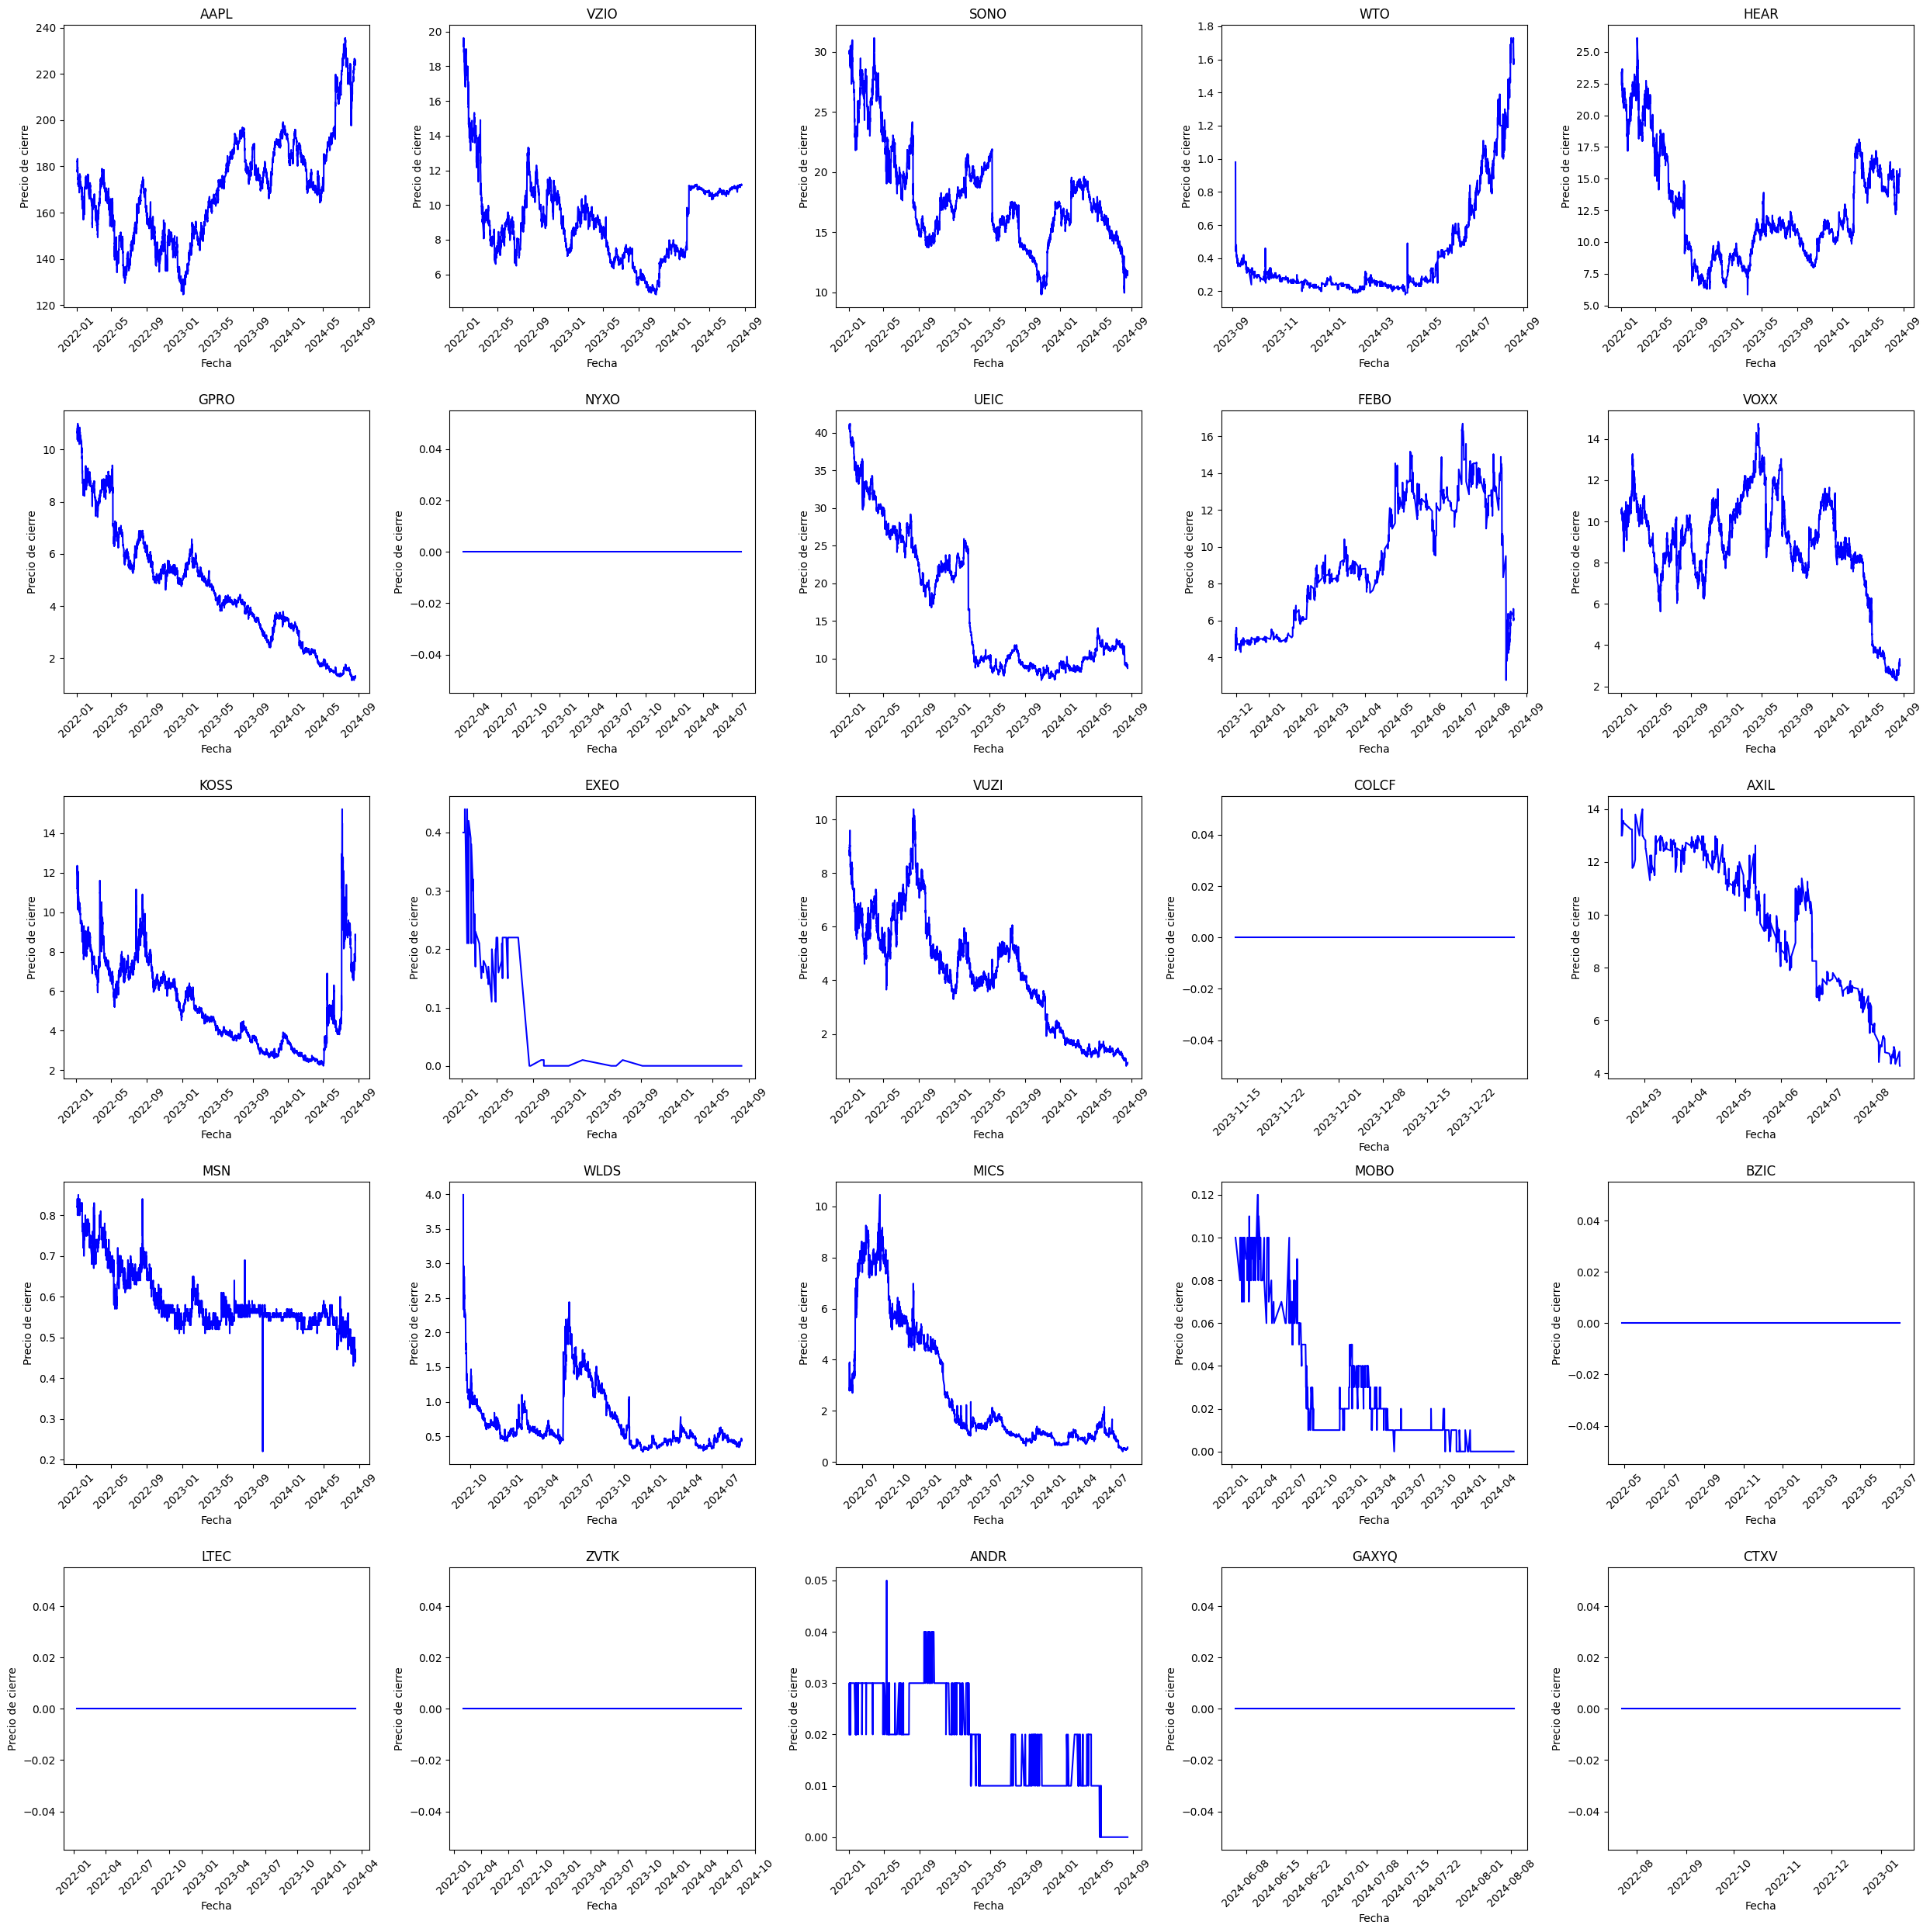

In [10]:
# grafico de lineas con el precio de cierre 5 acciones
fig, ax = plt.subplots(5, 5, figsize=(25, 25))
for i, ticker in enumerate(stocks_p['ticker'].unique()[:25]):
    data = stocks_p[stocks_p['ticker'] == ticker]
    ax[i//5, i%5].plot(data['date'], data['close_price'], color='blue')
    ax[i//5, i%5].set_title(f'{ticker}')
    ax[i//5, i%5].set_xlabel('Fecha')
    ax[i//5, i%5].set_ylabel('Precio de cierre')
    # rotate x labels
    for tick in ax[i//5, i%5].get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()

    


In [11]:
#cantidad de datos por cada compañía y precio de cierre promedio
groupstockprices = stocks_p.groupby('ticker').agg({'date': 'size', 'close_price': 'max', 'close_price': 'std', 'volume': 'mean'}).reset_index()
groupstockprices.columns = ['ticker', 'count', 'max_close_price', 'avg_volume']
groupstockprices.sort_values(by='count', ascending=False, inplace=True)
groupstockprices

,ticker,count,max_close_price,avg_volume
0,AAPL,10548,21.927228,3.902977e+06
9,GPRO,7816,2.237054,1.369566e+05
20,VUZI,7710,2.147756,7.474136e+04
17,SONO,6493,4.293701,1.998490e+05
21,VZIO,5889,2.395275,1.089660e+05
22,WLDS,5773,0.462044,1.101216e+05
11,KOSS,5649,2.310458,5.403906e+04
10,HEAR,5530,4.193421,3.163477e+04
19,VOXX,5092,2.525788,1.118293e+04
18,UEIC,5048,9.059061,8.354700e+03


In [12]:
groupstockprices = financial_news.groupby('ticker').agg({'published_date': 'size'}).reset_index()
groupstockprices.columns = ['ticker', 'count']
groupstockprices.sort_values(by='count', ascending=False, inplace=True)
groupstockprices

,ticker,count
0,AAPL,14135
8,SONO,224
3,GPRO,211
4,HEAR,150
13,WLDS,127
12,VZIO,121
11,VUZI,64
10,VOXX,46
6,MICS,40
9,UEIC,36


## Seleccion de datos de stocks price

In [13]:
stock_merge = pd.merge(stocks_p, groupstockprices[['ticker']], on='ticker', how='inner')
stock_merge.head()

,date,ticker,open_price,close_price,high_price,low_price,volume
0,2022-01-03 09:00:00,AAPL,178.26,178.08,178.34,177.76,60937
1,2022-01-03 10:00:00,AAPL,178.08,178.17,178.22,177.99,45629
2,2022-01-03 11:00:00,AAPL,178.17,178.45,178.46,178.16,39121
3,2022-01-03 12:00:00,AAPL,178.46,178.22,178.50,178.09,103317
4,2022-01-03 13:00:00,AAPL,178.37,177.65,178.48,177.57,440026


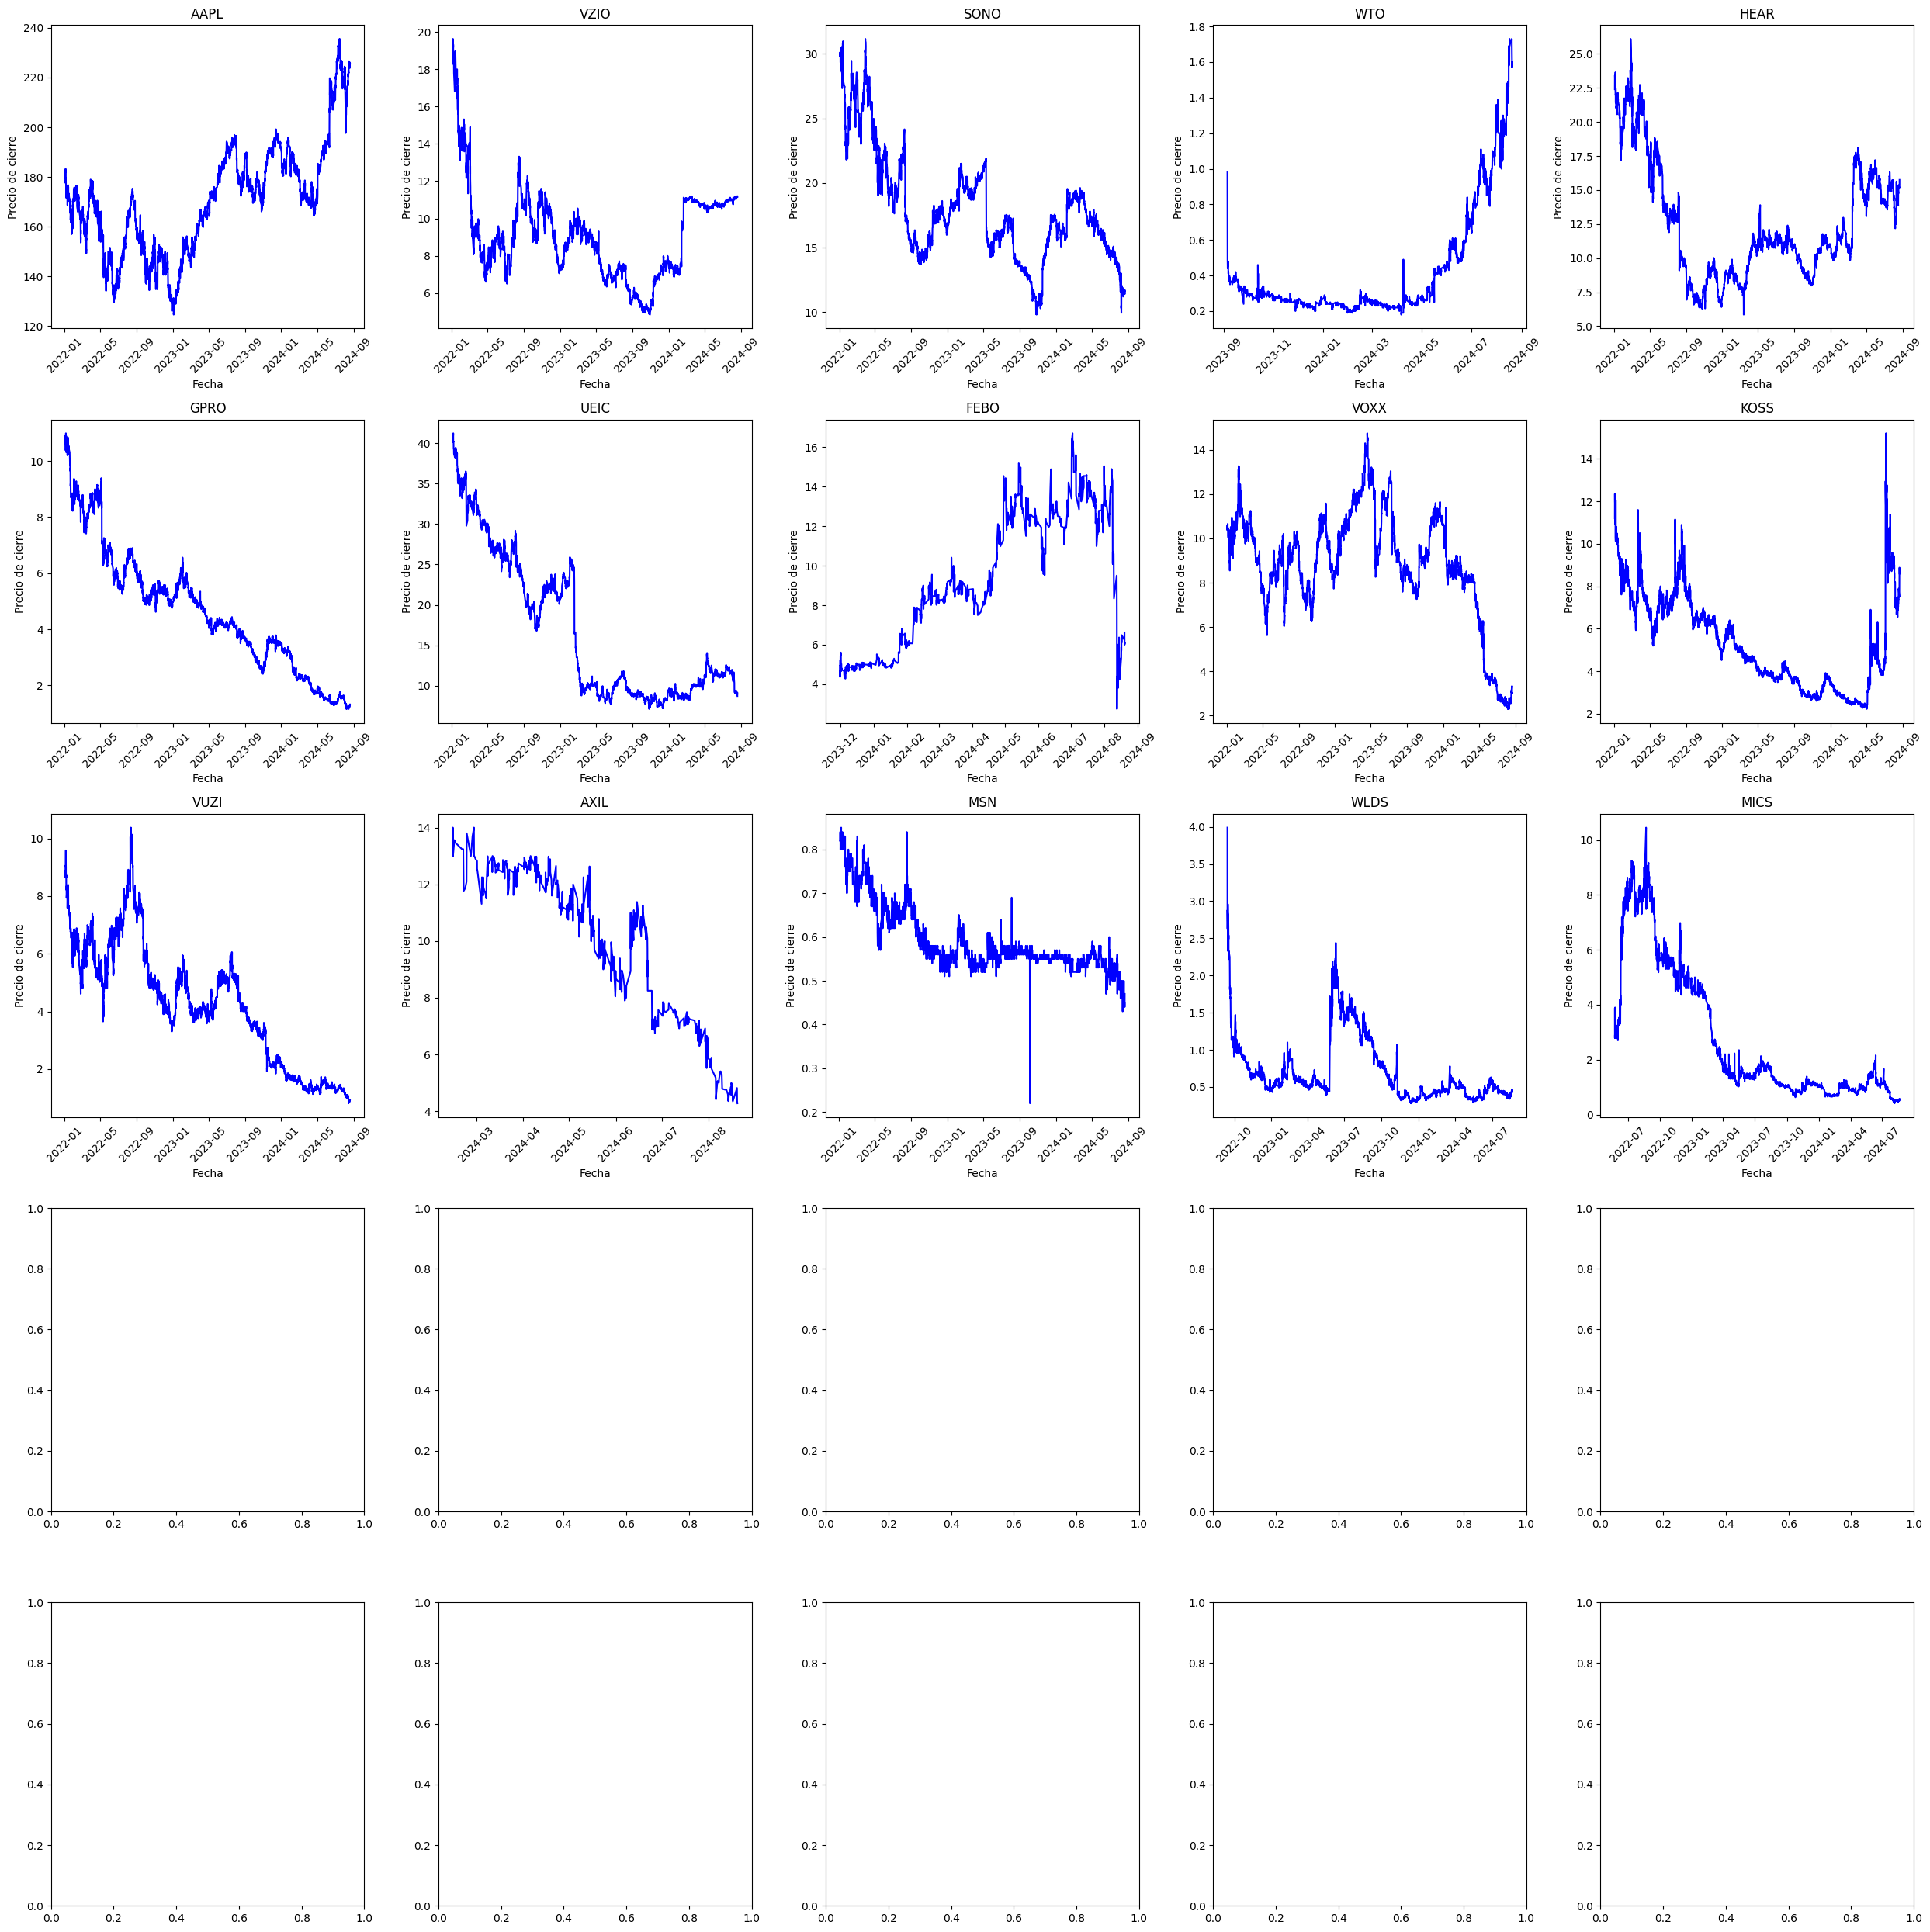

In [14]:
# grafico de lineas con el precio de cierre 5 acciones
fig, ax = plt.subplots(5, 5, figsize=(25, 25))
for i, ticker in enumerate(stock_merge['ticker'].unique()[:25]):
    data = stock_merge[stock_merge['ticker'] == ticker]
    ax[i//5, i%5].plot(data['date'], data['close_price'], color='blue')
    ax[i//5, i%5].set_title(f'{ticker}')
    ax[i//5, i%5].set_xlabel('Fecha')
    ax[i//5, i%5].set_ylabel('Precio de cierre')
    # rotate x labels
    for tick in ax[i//5, i%5].get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()


In [15]:
financial_news.head()

,id,title,url,published_date,company_id,content,description,ticker
0,15546,Fenbo Holdings Limited Announces Closing of It...,https://www.globenewswire.com/news-release/202...,2023-12-01 21:12:00,8,"Hong Kong, Dec. 01, 2023 (GLOBE NEWSWIRE) -- F...","Hong Kong, Dec. 01, 2023 (GLOBE NEWSWIRE) --...",FEBO
1,15547,Fenbo Holdings Limited Announces Appointment o...,https://www.globenewswire.com/news-release/202...,2024-01-03 21:30:00,8,"Hong Kong, Jan. 03, 2024 (GLOBE NEWSWIRE) -- F...","Hong Kong, Jan. 03, 2024 (GLOBE NEWSWIRE) --...",FEBO
2,15548,Singing Machine Announces Full Year Fiscal 202...,https://www.globenewswire.com/news-release/202...,2022-07-14 21:00:00,16,Singing Machine Reports $47.5 million in net s...,Singing Machine Reports $47.5 million in net s...,MICS
3,15549,Singing Machine Announces Launch of Proprietar...,https://www.globenewswire.com/news-release/202...,2022-07-21 13:30:00,16,Professional Quality Vocal EnhancementsDesigne...,Professional Quality Vocal EnhancementsDesigne...,MICS
4,15550,$6 Million Bet On Beacon Roofing Supply? 3 Sto...,https://www.benzinga.com/trading-ideas/long-id...,2022-08-01 12:17:15,16,"Although US stocks closed higher on Friday, th...","Although US stocks closed higher on Friday, th...",MICS


In [16]:
financial_news['published_date'] = pd.to_datetime(financial_news['published_date'])
financial_news['dateHour'] = financial_news['published_date'].dt.strftime('%Y-%m-%d %H')

In [17]:
fnGrouped =  financial_news.groupby(['ticker', 'dateHour']).size().reset_index(name='count')
fnGrouped.head()

,ticker,dateHour,count
0,AAPL,2022-01-03 04,1
1,AAPL,2022-01-03 05,1
2,AAPL,2022-01-03 08,1
3,AAPL,2022-01-03 09,1
4,AAPL,2022-01-03 10,1


In [18]:
stock_merge['dateHour'] = stock_merge['date'].dt.strftime('%Y-%m-%d %H')
stock_merge = pd.merge(stock_merge, fnGrouped, on=['ticker', 'dateHour'], how='left')
stock_merge['newsCount'] = stock_merge['count']
stock_merge = stock_merge.drop(columns=['count', 'dateHour'])
stock_merge['newsCount'] = stock_merge['newsCount'].fillna(0)
stock_merge['newsCount'] = stock_merge['newsCount'].astype(int)
stock_merge.head()


,date,ticker,open_price,close_price,high_price,low_price,volume,newsCount
0,2022-01-03 09:00:00,AAPL,178.26,178.08,178.34,177.76,60937,1
1,2022-01-03 10:00:00,AAPL,178.08,178.17,178.22,177.99,45629,1
2,2022-01-03 11:00:00,AAPL,178.17,178.45,178.46,178.16,39121,4
3,2022-01-03 12:00:00,AAPL,178.46,178.22,178.50,178.09,103317,2
4,2022-01-03 13:00:00,AAPL,178.37,177.65,178.48,177.57,440026,1


In [19]:
stock_merge['newsCount'] = np.where(stock_merge['newsCount'] > 0, 1, 0)
stock_merge['newsStockPrice'] = stock_merge['newsCount'] * stock_merge['close_price']

In [20]:
stock_merge.query('newsCount > 0').tail()

,date,ticker,open_price,close_price,high_price,low_price,volume,newsCount,newsStockPrice
75653,2024-01-08 13:00:00,MICS,1.00,1.15,1.15,1.00,900,1,1.15
75839,2024-02-27 12:00:00,MICS,0.73,0.80,0.80,0.73,1599,1,0.80
75845,2024-02-27 18:00:00,MICS,0.98,1.07,1.12,0.94,146668,1,1.07
76197,2024-05-23 12:00:00,MICS,1.42,1.48,1.75,1.35,26694,1,1.48
76296,2024-06-12 11:00:00,MICS,2.00,2.16,2.58,1.97,2492562,1,2.16


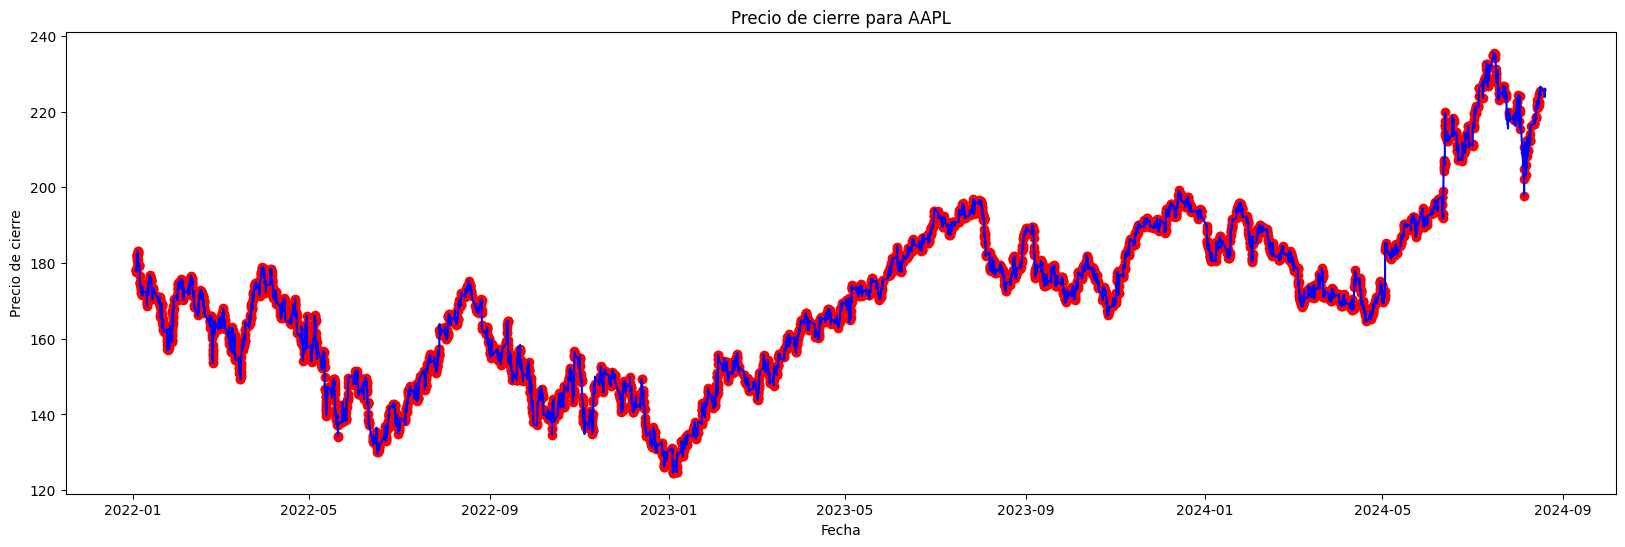

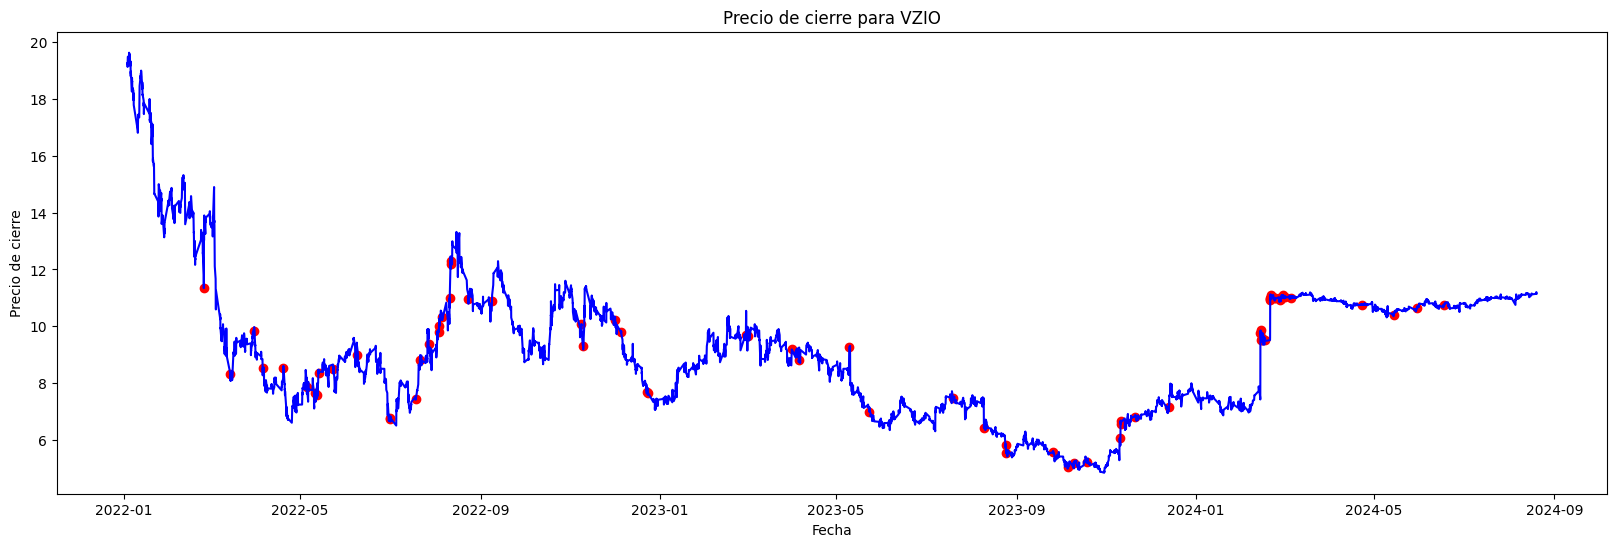

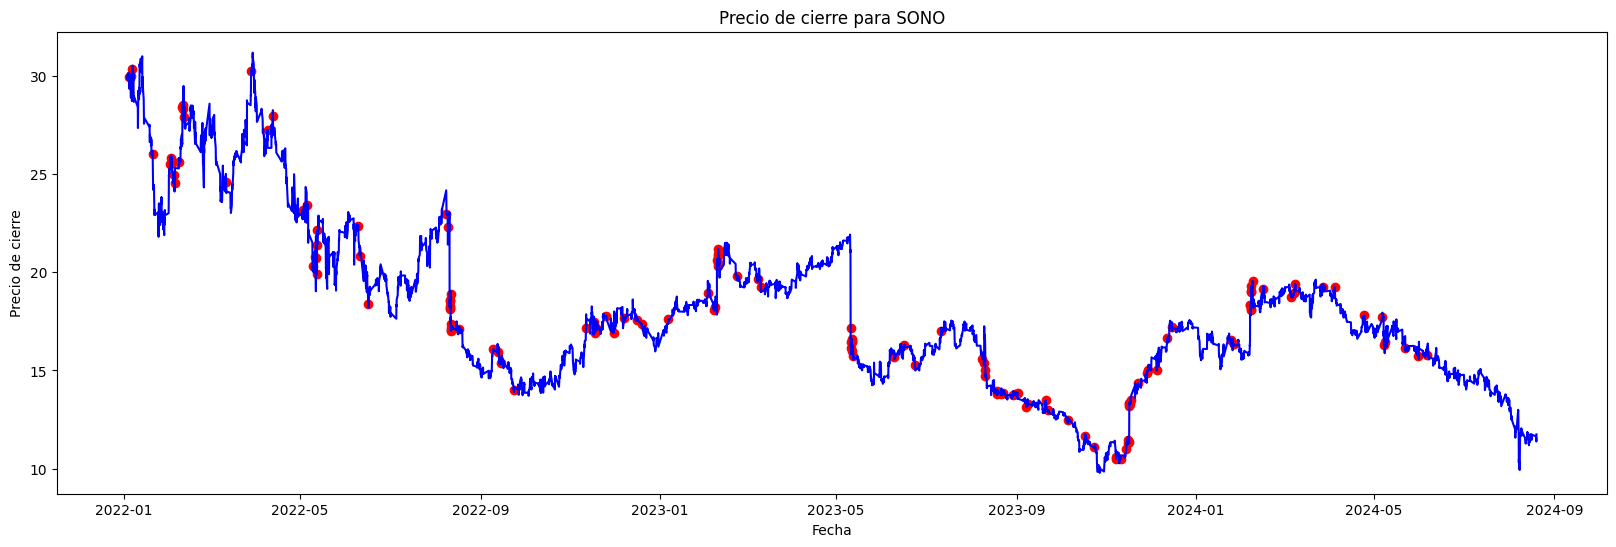

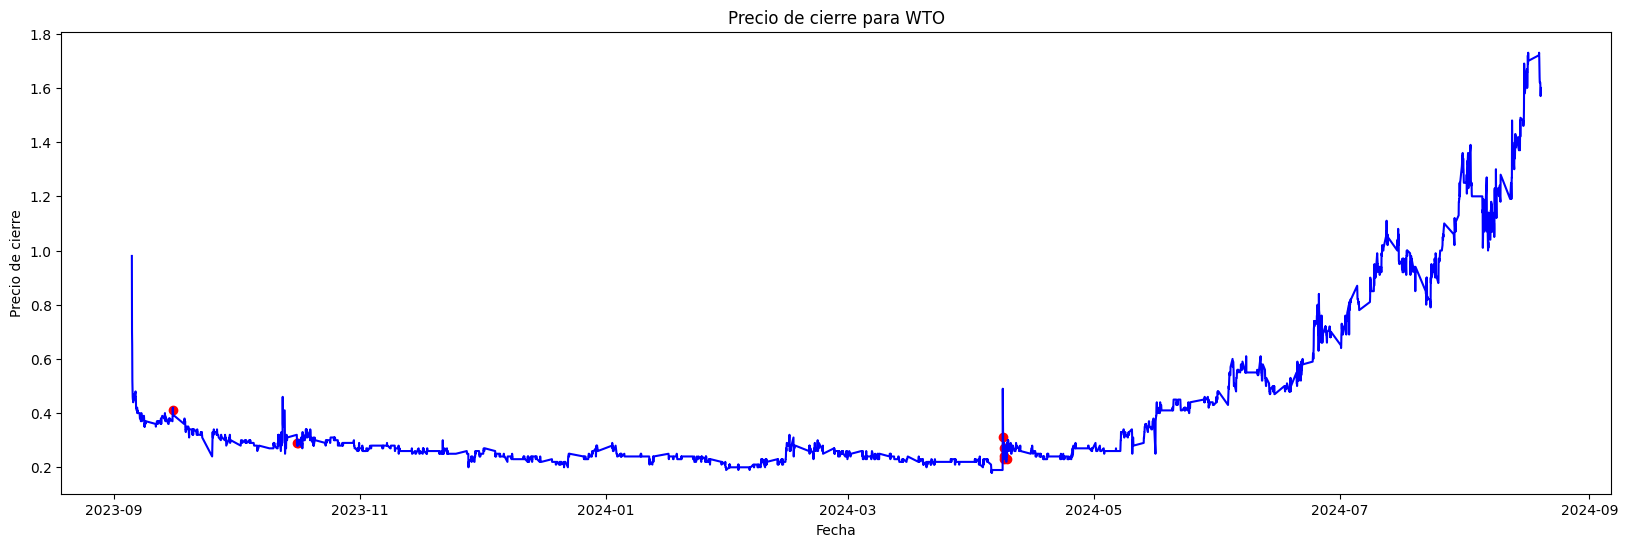

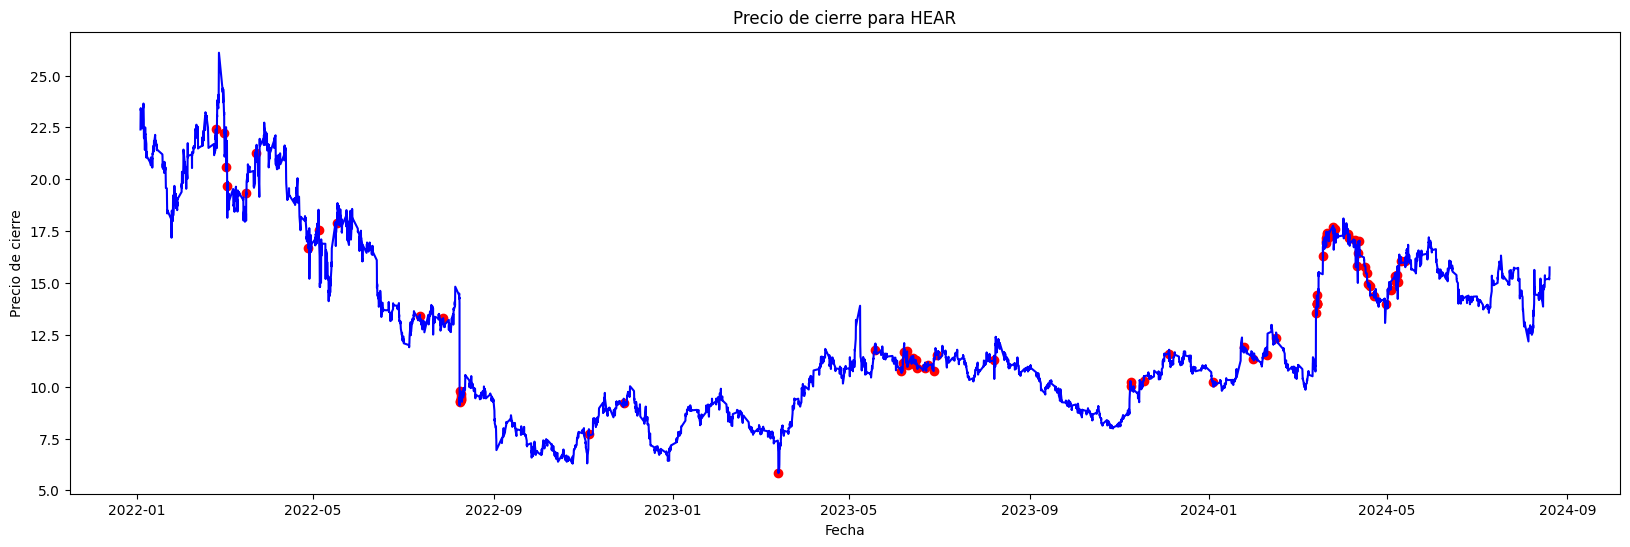

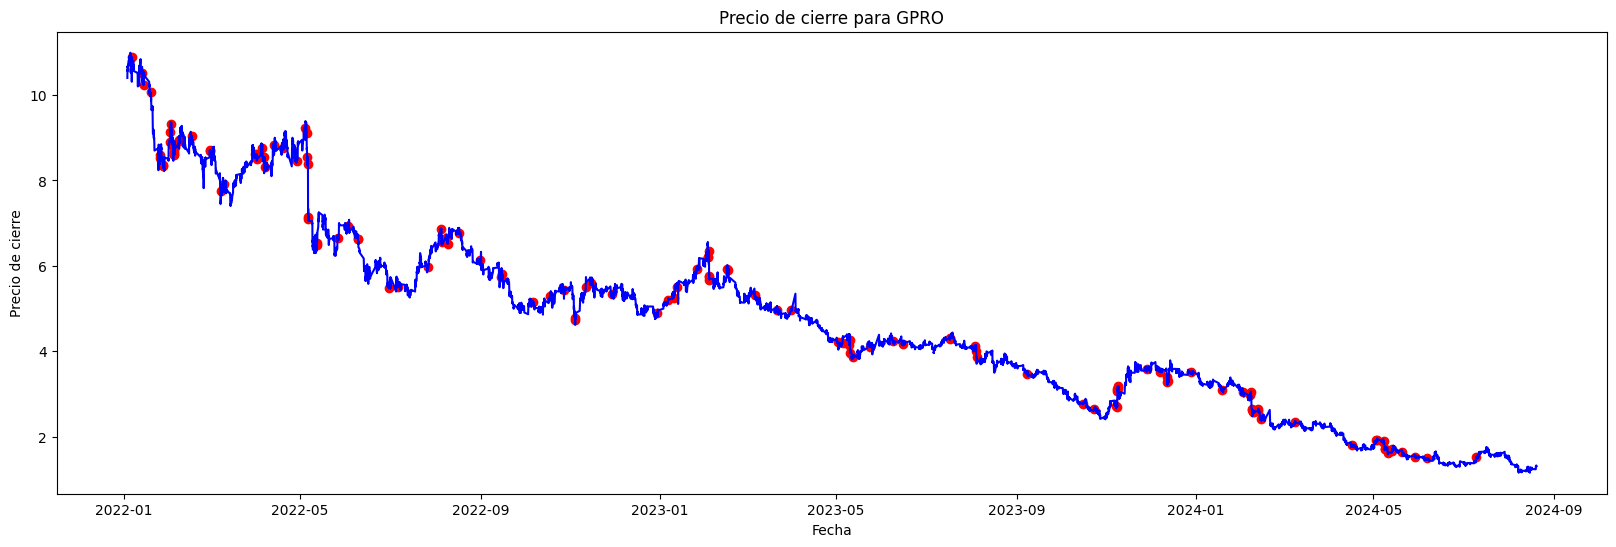

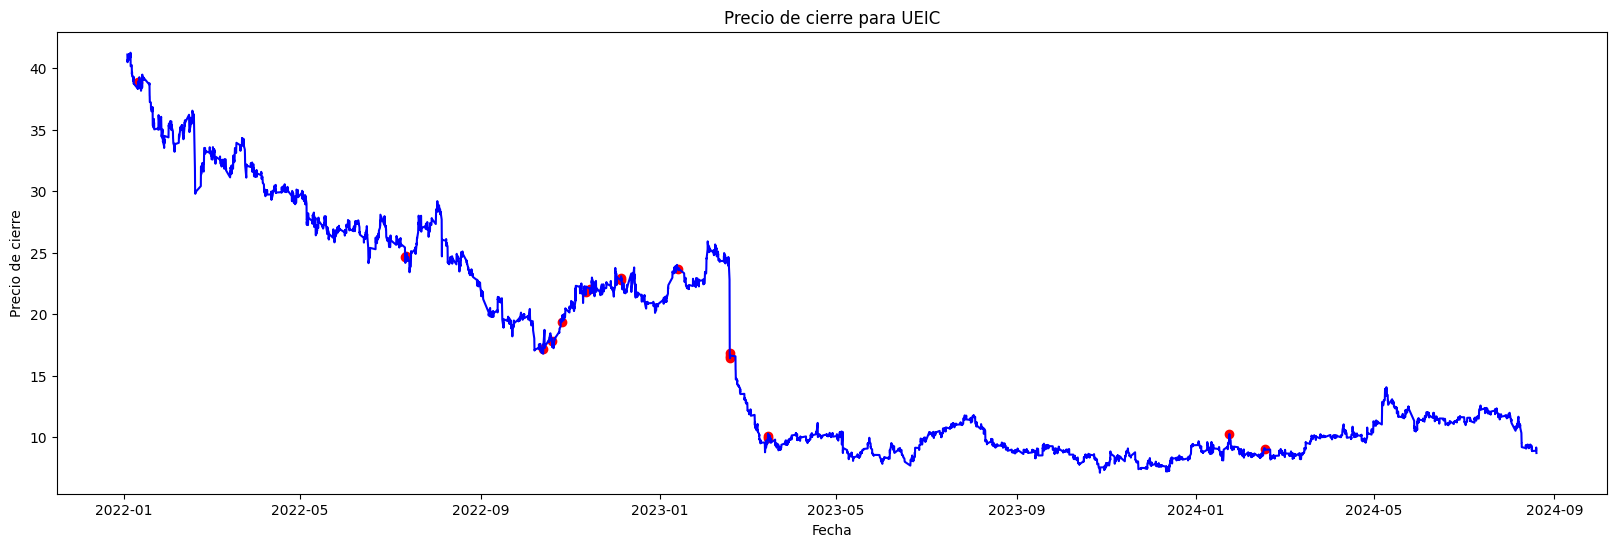

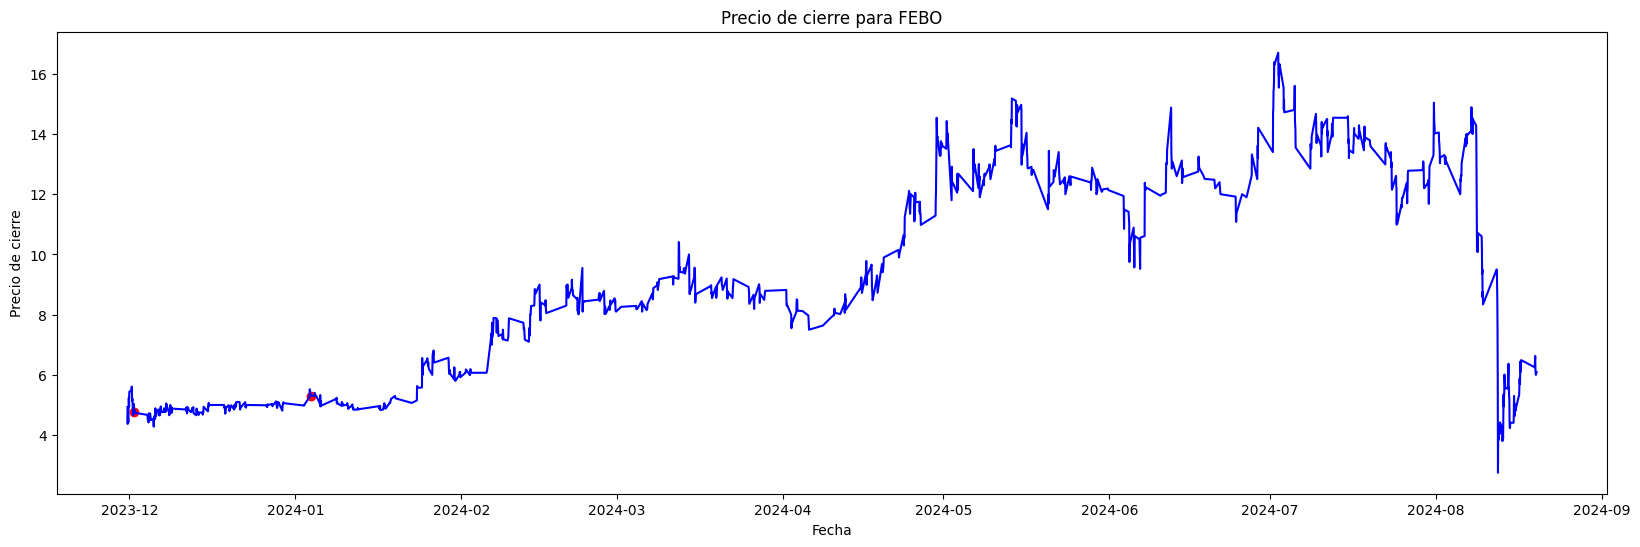

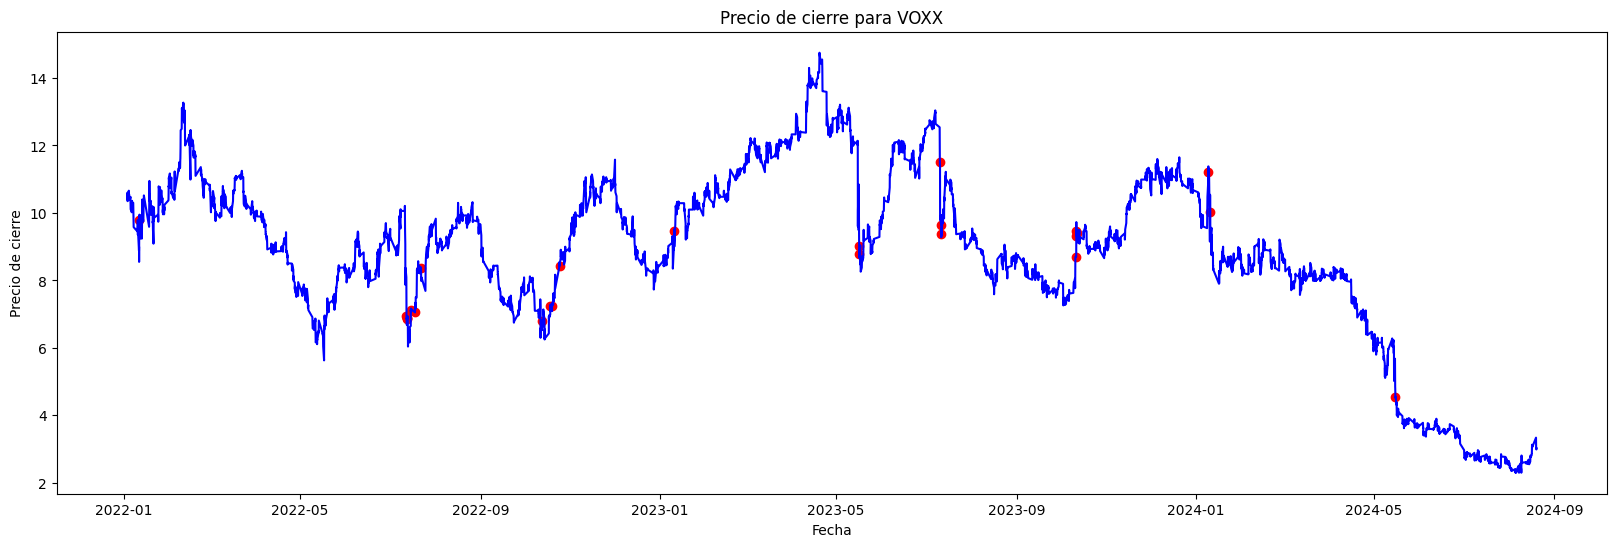

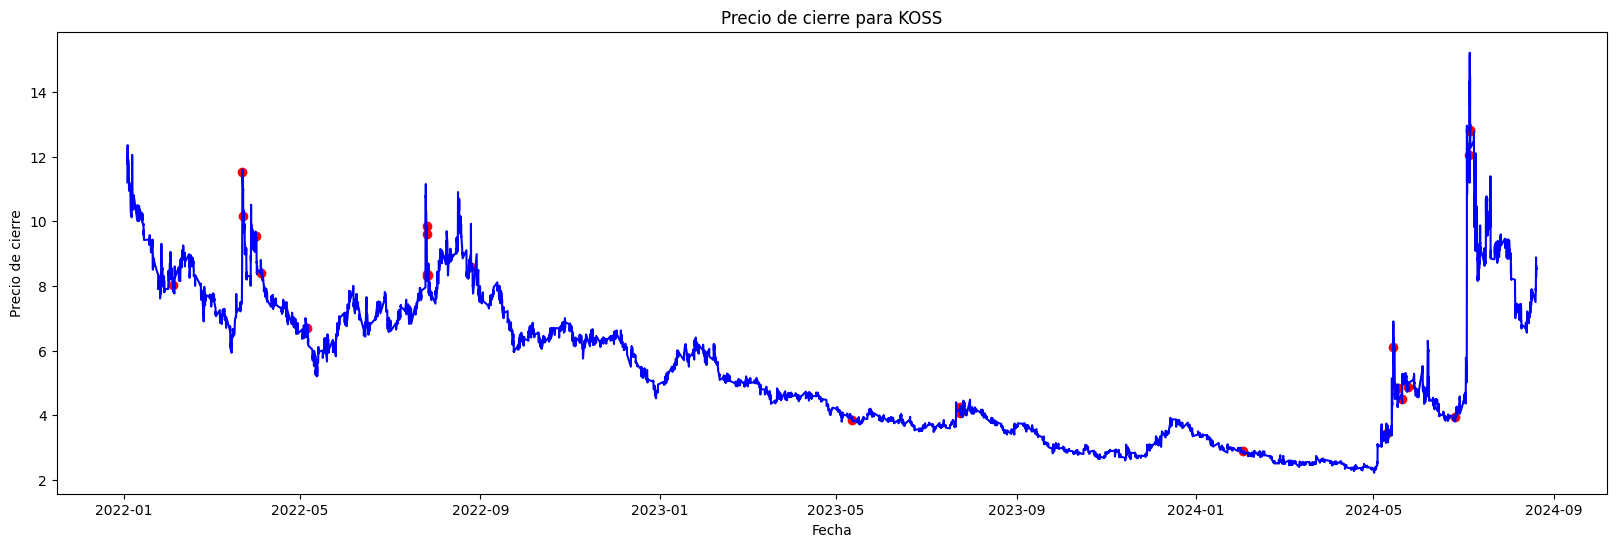

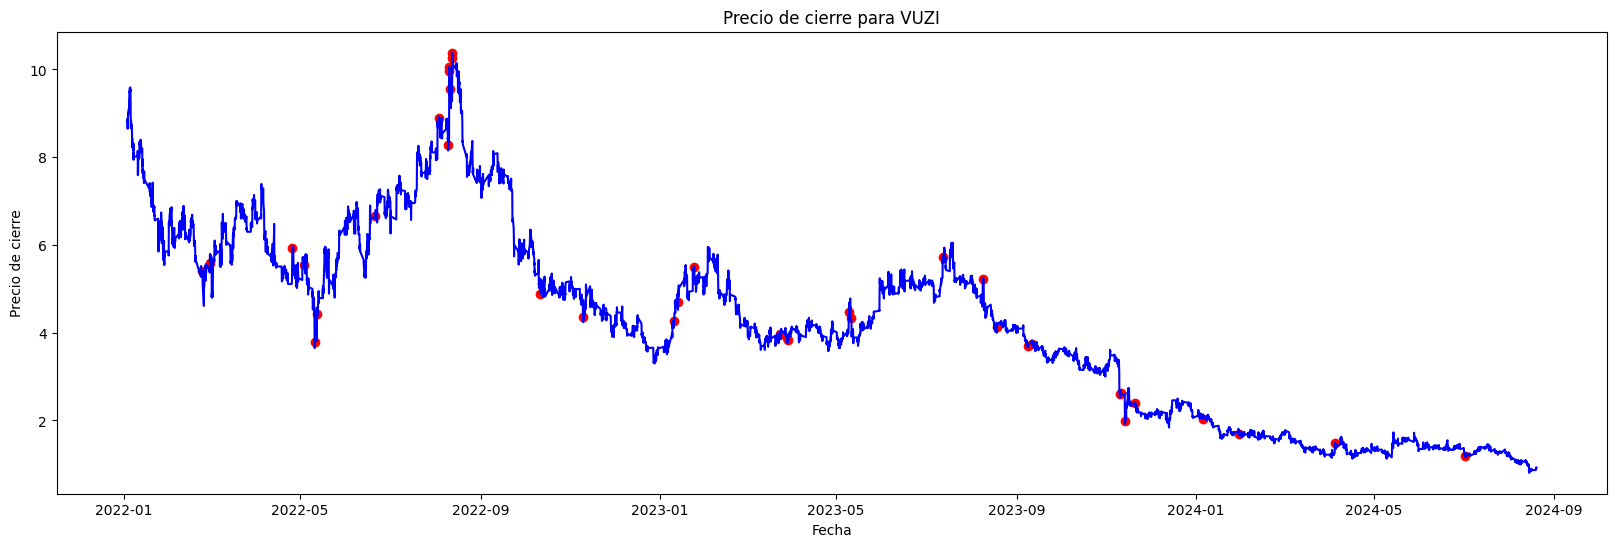

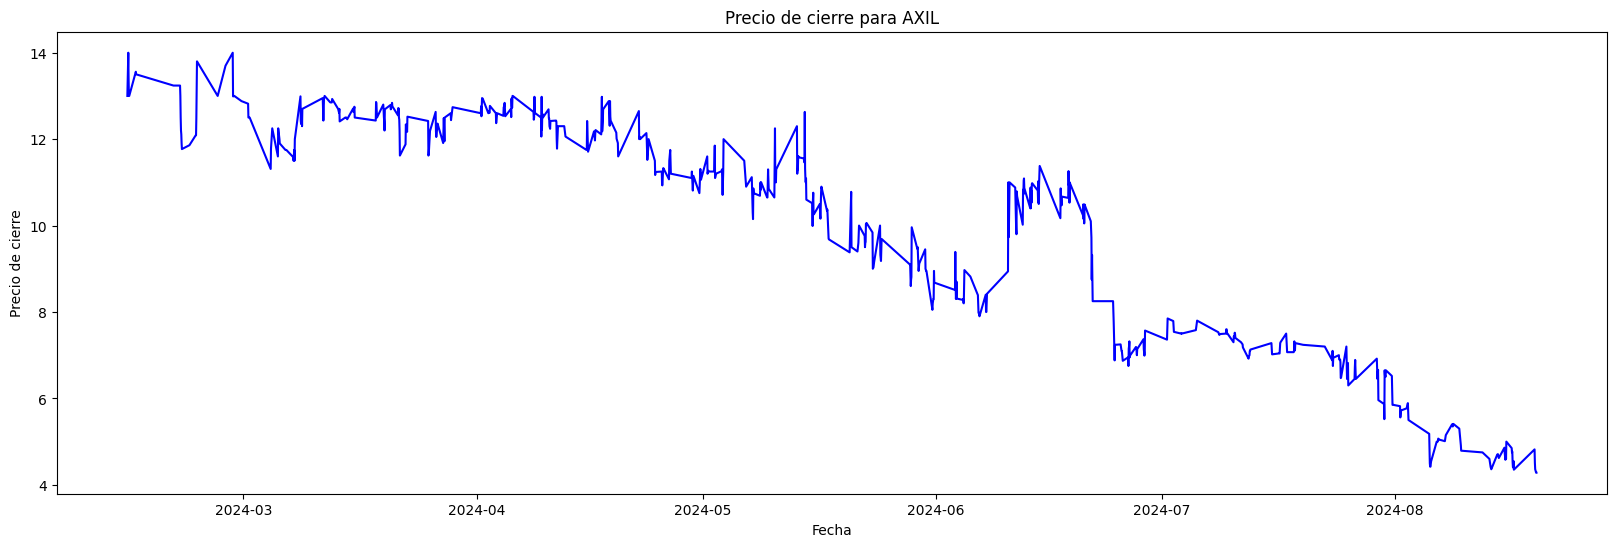

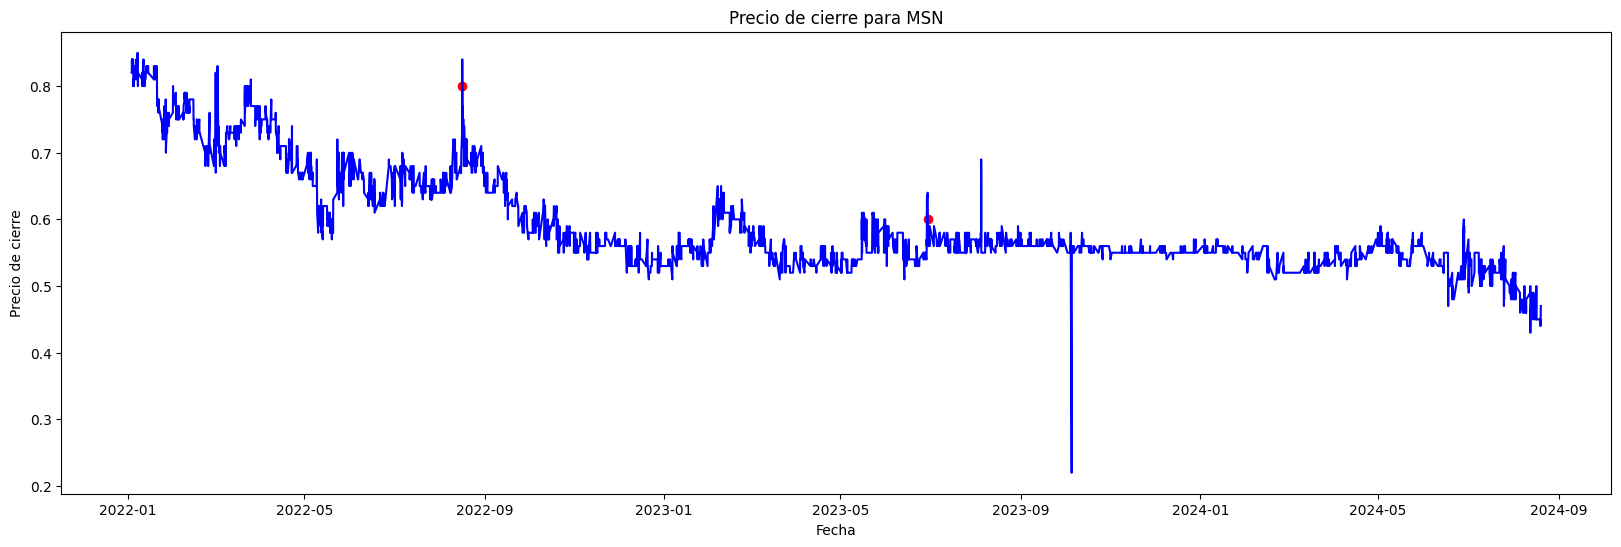

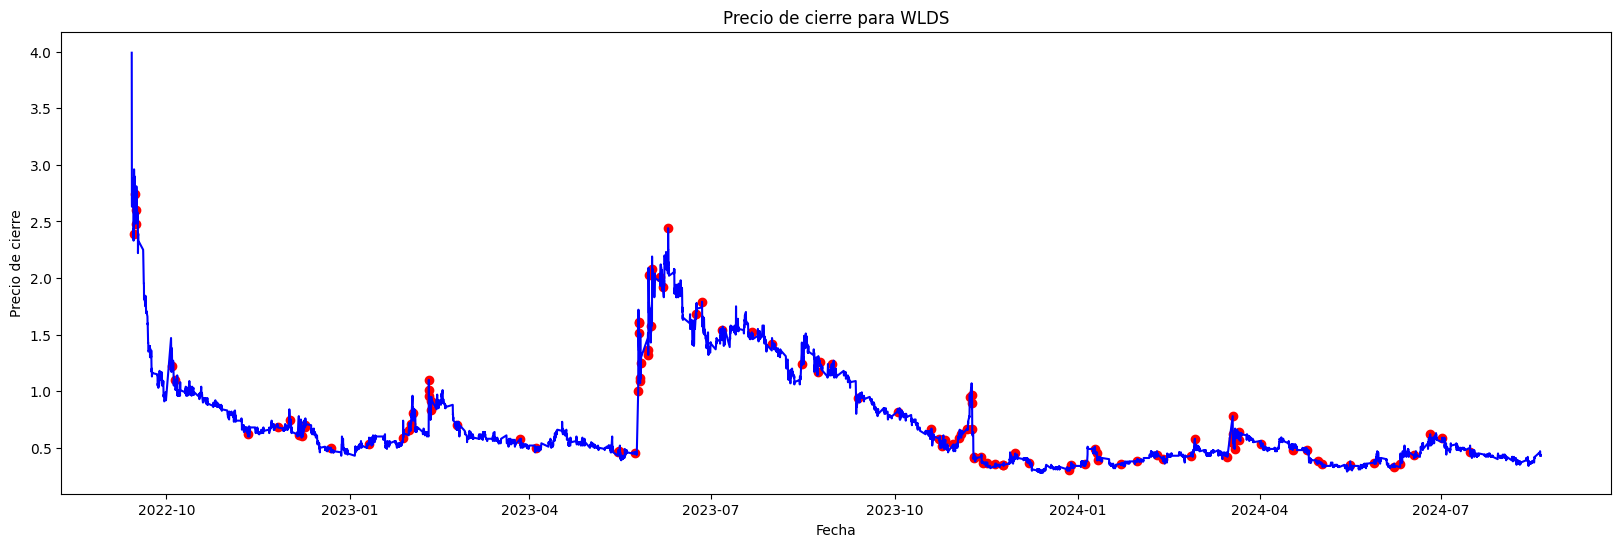

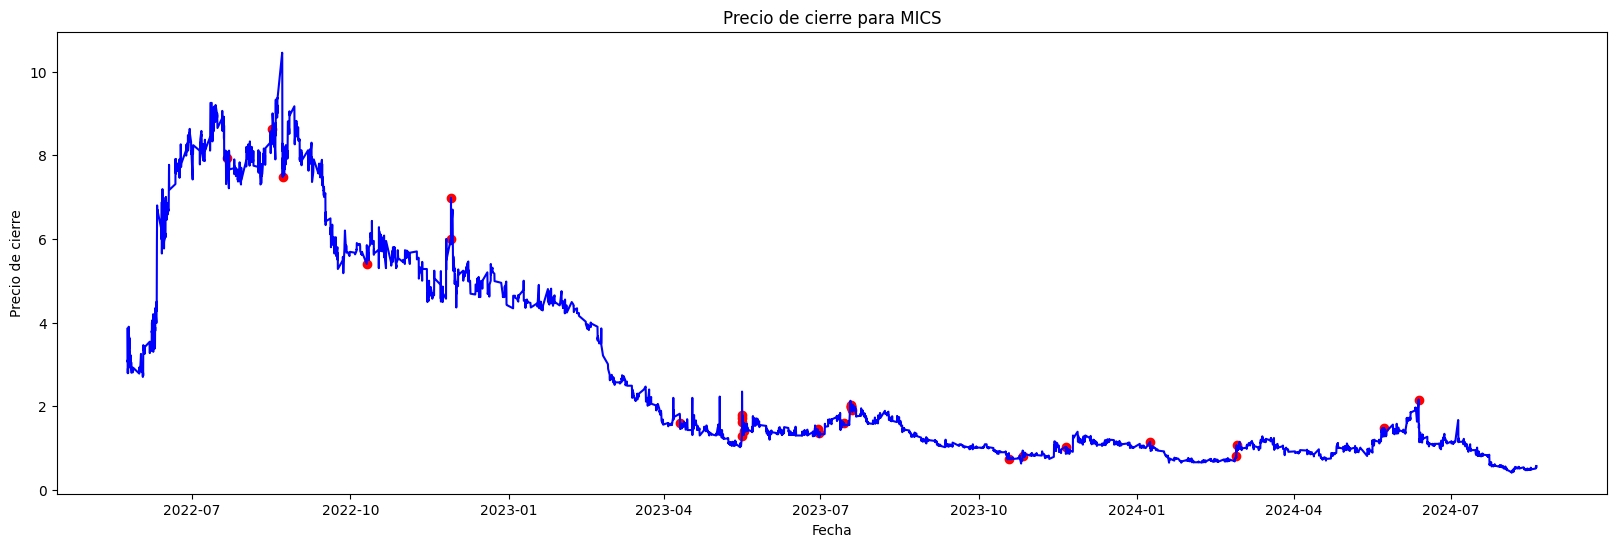

In [21]:
# grafico de lineas con el precio de cierre 5 acciones con puntos donde hay noticias
for ticker in stock_merge['ticker'].unique():
    data = stock_merge[stock_merge['ticker'] == ticker]
    plt.figure(figsize=(20, 6))
    plt.plot(data['date'], data['close_price'], color='blue')
    plt.scatter(data[data['newsCount'] > 0]['date'], data[data['newsCount'] > 0]['close_price'], color='red')
    plt.title(f'Precio de cierre para {ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de cierre')
    plt.show()

In [22]:
stock_merge.head()

,date,ticker,open_price,close_price,high_price,low_price,volume,newsCount,newsStockPrice
0,2022-01-03 09:00:00,AAPL,178.26,178.08,178.34,177.76,60937,1,178.08
1,2022-01-03 10:00:00,AAPL,178.08,178.17,178.22,177.99,45629,1,178.17
2,2022-01-03 11:00:00,AAPL,178.17,178.45,178.46,178.16,39121,1,178.45
3,2022-01-03 12:00:00,AAPL,178.46,178.22,178.50,178.09,103317,1,178.22
4,2022-01-03 13:00:00,AAPL,178.37,177.65,178.48,177.57,440026,1,177.65


In [23]:
stock_merge.to_csv('../data/processed/stock_prices.csv', index=False)

# Noticias

## Preparacion de los datos

In [24]:
# Ver las primeras filas
financial_news.head()

,id,title,url,published_date,company_id,content,description,ticker,dateHour
0,15546,Fenbo Holdings Limited Announces Closing of It...,https://www.globenewswire.com/news-release/202...,2023-12-01 21:12:00,8,"Hong Kong, Dec. 01, 2023 (GLOBE NEWSWIRE) -- F...","Hong Kong, Dec. 01, 2023 (GLOBE NEWSWIRE) --...",FEBO,2023-12-01 21
1,15547,Fenbo Holdings Limited Announces Appointment o...,https://www.globenewswire.com/news-release/202...,2024-01-03 21:30:00,8,"Hong Kong, Jan. 03, 2024 (GLOBE NEWSWIRE) -- F...","Hong Kong, Jan. 03, 2024 (GLOBE NEWSWIRE) --...",FEBO,2024-01-03 21
2,15548,Singing Machine Announces Full Year Fiscal 202...,https://www.globenewswire.com/news-release/202...,2022-07-14 21:00:00,16,Singing Machine Reports $47.5 million in net s...,Singing Machine Reports $47.5 million in net s...,MICS,2022-07-14 21
3,15549,Singing Machine Announces Launch of Proprietar...,https://www.globenewswire.com/news-release/202...,2022-07-21 13:30:00,16,Professional Quality Vocal EnhancementsDesigne...,Professional Quality Vocal EnhancementsDesigne...,MICS,2022-07-21 13
4,15550,$6 Million Bet On Beacon Roofing Supply? 3 Sto...,https://www.benzinga.com/trading-ideas/long-id...,2022-08-01 12:17:15,16,"Although US stocks closed higher on Friday, th...","Although US stocks closed higher on Friday, th...",MICS,2022-08-01 12


In [25]:
# Información general
financial_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15205 entries, 0 to 15204
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              15205 non-null  int64         
 1   title           15205 non-null  object        
 2   url             15205 non-null  object        
 3   published_date  15205 non-null  datetime64[ns]
 4   company_id      15205 non-null  int64         
 5   content         15205 non-null  object        
 6   description     15205 non-null  object        
 7   ticker          15205 non-null  object        
 8   dateHour        15205 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 1.0+ MB


In [26]:
financial_news.describe()

,id,published_date,company_id
count,15205.000000,15205,15205.000000
mean,23148.000000,2023-03-19 17:14:39.804867072,1.402105
min,15546.000000,2022-01-03 04:04:21,1.000000
25%,19347.000000,2022-07-21 21:50:00,1.000000
50%,23148.000000,2023-03-06 11:20:07,1.000000
75%,26949.000000,2023-11-10 21:00:00,1.000000
max,30750.000000,2024-08-18 22:14:00,16.000000
std,4389.449757,NaN,1.833211


### Identificar nulos

In [27]:
financial_news.sort_values(by='company_id', ascending=False, inplace=True)
financial_news.replace('', np.nan, inplace=True)
financial_news.isnull().sum()

id                   0
title                0
url                  0
published_date       0
company_id           0
content           7559
description          0
ticker               0
dateHour             0
dtype: int64

### Imputar nulos

In [28]:
# Vacios de contenido rellenar con descripción
financial_news['content'].fillna(financial_news['description'], inplace=True)
financial_news.isnull().sum()

/var/folders/y8/47g68xbd29xckbntjt_qw1w00000gn/T/ipykernel_23017/2864760014.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  financial_news['content'].fillna(financial_news['description'], inplace=True)


id                0
title             0
url               0
published_date    0
company_id        0
content           0
description       0
ticker            0
dateHour          0
dtype: int64

In [29]:
financial_news['content'] = financial_news.apply(lambda x: x['description'] if x['content'] == "Analyst CalendarJoin Benzinga Edge and unlock all the major upgrades, downgrades, and changes to the market's most accurate analysts." else x['content'], axis=1)

### Limpiar/Tokenizar/Lemantizar

In [30]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remover caracteres especiales y números
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convertir a minúsculas
    text = text.lower()
    # Tokenizar
    tokens = nltk.word_tokenize(text)
    # Remover stop words y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Unir de nuevo
    cleaned_text = ' '.join(tokens)
    return cleaned_text

financial_news['cleaned_text'] = financial_news['content'].apply(clean_text)
financial_news['tokens'] = financial_news['cleaned_text'].apply(nltk.word_tokenize)

In [31]:
financial_news['len_tokens'] = financial_news['tokens'].apply(len)
financial_news['len_tokens'].describe()

count    15205.000000
mean       245.289905
std        464.727551
min          1.000000
25%         14.000000
50%         49.000000
75%        388.000000
max       7612.000000
Name: len_tokens, dtype: float64

<Axes: title={'center': 'Cantidad de noticias por cantidad de tokens'}, xlabel='len_tokens'>

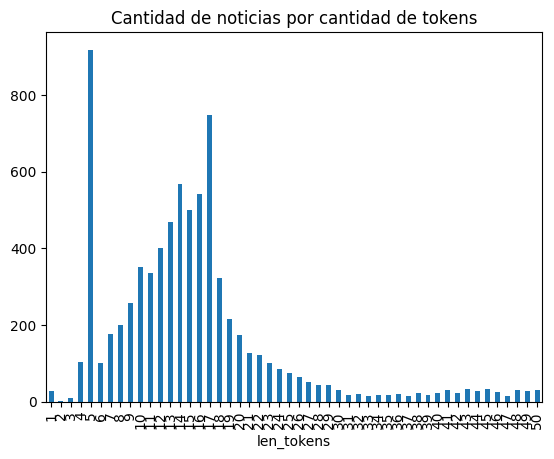

In [32]:
financial_news.len_tokens.value_counts().sort_index().head(50).plot(kind='bar', title='Cantidad de noticias por cantidad de tokens')

In [33]:
financial_news_clean = financial_news.query("cleaned_text != 'earnings calendarnever miss important catalystssort estimate projected upside profit surprise easily find new stock invest check portfolio'").copy()
financial_news_clean = financial_news_clean.query("len_tokens > 5").copy()

<Axes: title={'center': 'Cantidad de noticias por cantidad de tokens'}, xlabel='len_tokens'>

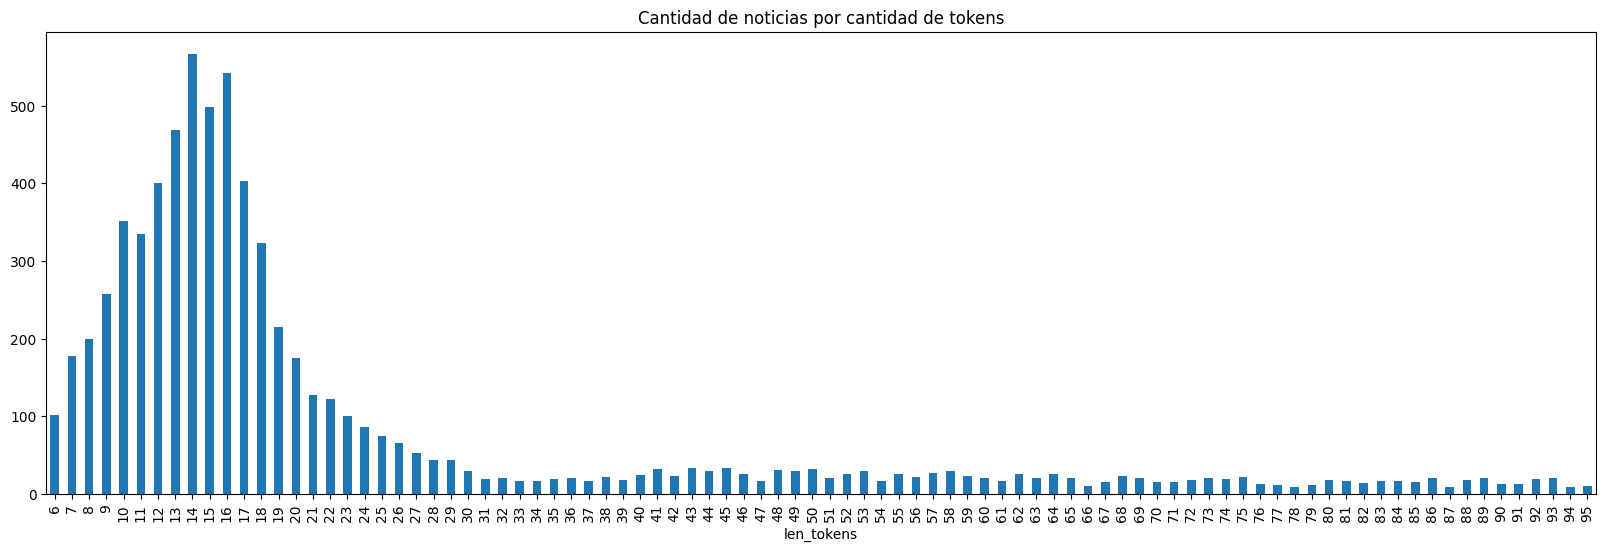

In [34]:
financial_news_clean.len_tokens.value_counts().sort_index().head(90).plot(kind='bar', title='Cantidad de noticias por cantidad de tokens', figsize=(20, 6))

In [35]:
financial_news_clean.query("len_tokens == 12")

,id,title,url,published_date,company_id,content,description,ticker,dateHour,cleaned_text,tokens,len_tokens
14821,30367,"GoPro's (GPRO) Q2 Loss In Line, Revenues Surpa...",https://www.zacks.com/stock/news/2132857/gopro...,2023-08-04 17:10:00,6,GoPro's (GPRO) Q2 performance gains from highe...,GoPro's (GPRO) Q2 performance gains from highe...,GPRO,2023-08-04 17,gopro gpro q performance gain higher retail su...,"[gopro, gpro, q, performance, gain, higher, re...",12
14838,30384,GoPro's (GPRO) Q3 Earnings & Revenues Surpass ...,https://www.zacks.com/stock/news/2180578/gopro...,2023-11-08 10:39:00,6,GoPro's (GPRO) Q3 performance gains from highe...,GoPro's (GPRO) Q3 performance gains from highe...,GPRO,2023-11-08 10,gopro gpro q performance gain higher retail su...,"[gopro, gpro, q, performance, gain, higher, re...",12
14840,30386,David Einhorn's Greenlight Capital invests in ...,https://www.marketwatch.com/story/david-einhor...,2023-11-15 10:50:00,6,"The New York hedge fund, which controls $1.7 b...","The New York hedge fund, which controls $1.7 b...",GPRO,2023-11-15 10,new york hedge fund control billion asset plow...,"[new, york, hedge, fund, control, billion, ass...",12
14709,30255,Why This 1 Value Stock Could Be a Great Additi...,https://www.zacks.com/stock/news/1870555/why-t...,2022-02-21 15:00:09,6,"Wondering how to pick strong, market-beating s...","Wondering how to pick strong, market-beating s...",GPRO,2022-02-21 15,wondering pick strong market beating stock inv...,"[wondering, pick, strong, market, beating, sto...",12
14732,30278,"This trader predicted the bond meltdown, tech ...",https://www.marketwatch.com/story/this-trader-...,2022-05-05 13:55:00,6,"Our call of the day comes from Samantha LaDuc,...","Our call of the day comes from Samantha LaDuc,...",GPRO,2022-05-05 13,call day come samantha laduc say market wrong ...,"[call, day, come, samantha, laduc, say, market...",12
...,...,...,...,...,...,...,...,...,...,...,...,...
4987,20533,Are You a Growth Investor? This 1 Stock Could ...,https://www.zacks.com/stock/news/1992727/are-y...,2022-10-17 13:45:07,1,"Wondering how to pick strong, market-beating s...","Wondering how to pick strong, market-beating s...",AAPL,2022-10-17 13,wondering pick strong market beating stock inv...,"[wondering, pick, strong, market, beating, sto...",12
5068,20614,Amphenol (APH) to Report Q3 Earnings: What's i...,https://www.zacks.com/stock/news/1995698/amphe...,2022-10-21 14:09:00,1,Amphenol's (APH) third-quarter 2022 results ar...,Amphenol's (APH) third-quarter 2022 results ar...,AAPL,2022-10-21 14,amphenol aph third quarter result likely refle...,"[amphenol, aph, third, quarter, result, likely...",12
5045,20591,Meta Platforms (META) Banks on AI to Boost Gro...,https://www.zacks.com/stock/news/1994831/meta-...,2022-10-20 13:45:00,1,Meta Platforms (META) is banking on AI to buil...,Meta Platforms (META) is banking on AI to buil...,AAPL,2022-10-20 13,meta platform meta banking ai build new soluti...,"[meta, platform, meta, banking, ai, build, new...",12
5326,20872,The 2022 Kia EV6 vs. the 2023 Volkswagen ID.4:...,https://www.marketwatch.com/story/the-2022-kia...,2022-11-02 08:03:00,1,The Volkswagen has a lot of practical traits a...,The Volkswagen has a lot of practical traits a...,AAPL,2022-11-02 08,volkswagen lot practical trait clever user int...,"[volkswagen, lot, practical, trait, clever, us...",12


### Etiquetar

In [36]:
lm = ps.LM()
def get_sentiment_pysentiment(text):
    tokens = lm.tokenize(text)
    score = lm.get_score(tokens)
    if score['Positive'] > score['Negative']:
        sentiment = 'positive'
        scr = score['Positive']
    elif score['Positive'] < score['Negative']:
        sentiment = 'negative'
        scr = score['Negative']
    else:
        sentiment = 'neutral'
        scr = 0
    
    return sentiment, scr, score['Polarity']

financial_news_clean[['sentiment_label_ps', 'score_ps', 'sentiment_score_ps']] = financial_news_clean['cleaned_text'].apply(get_sentiment_pysentiment).apply(pd.Series)

In [37]:
financial_news_clean.head()

,id,title,url,published_date,company_id,content,description,ticker,dateHour,cleaned_text,tokens,len_tokens,sentiment_label_ps,score_ps,sentiment_score_ps
36,15582,Singing Machine and Stingray Unveil New Karaok...,https://www.globenewswire.com/news-release/202...,2024-01-08 13:00:00,16,Stingray and Singing Machine partner to debut ...,Stingray and Singing Machine partner to debut ...,MICS,2024-01-08 13,stingray singing machine partner debut major n...,"[stingray, singing, machine, partner, debut, m...",651,positive,25,0.666667
21,15567,Singing Machine Announces New Partnership with...,https://www.globenewswire.com/news-release/202...,2023-06-29 12:00:00,16,"Fort Lauderdale, FL, June 29, 2023 (GLOBE NEWS...","Fort Lauderdale, FL, June 29, 2023 (GLOBE NE...",MICS,2023-06-29 12,fort lauderdale fl june globe newswire singing...,"[fort, lauderdale, fl, june, globe, newswire, ...",464,positive,17,0.619048
23,15569,Singing Machine Announces Updated Time for Ear...,https://www.globenewswire.com/news-release/202...,2023-07-13 20:05:00,16,"Fort Lauderdale, FL, July 13, 2023 (GLOBE NEWS...","Fort Lauderdale, FL, July 13, 2023 (GLOBE NE...",MICS,2023-07-13 20,fort lauderdale fl july globe newswire singing...,"[fort, lauderdale, fl, july, globe, newswire, ...",294,negative,4,-0.142857
24,15570,Singing Machine Announces Financial Results fo...,https://www.globenewswire.com/news-release/202...,2023-07-14 20:05:00,16,"Fort Lauderdale, FL, July 14, 2023 (GLOBE NEWS...","Fort Lauderdale, FL, July 14, 2023 (GLOBE NE...",MICS,2023-07-14 20,fort lauderdale fl july globe newswire singing...,"[fort, lauderdale, fl, july, globe, newswire, ...",1232,negative,31,-0.192308
26,15572,Why Lixte Biotechnology Shares Are Trading Low...,https://www.benzinga.com/news/23/07/33271322/w...,2023-07-18 17:00:51,16,"Gainers Pieris Pharmaceuticals, Inc. PIRS gain...","Gainers\n\nPieris Pharmaceuticals, Inc. (NASDA...",MICS,2023-07-18 17,gainer pieris pharmaceutical inc pirs gained c...,"[gainer, pieris, pharmaceutical, inc, pirs, ga...",478,negative,15,-0.428571


## Nueva propuesta de transformer

In [38]:
pipe = pipeline("text-classification", model="ProsusAI/finbert", device=0)

def get_sentiment_finbert_lt512(text):
    # Dividir texto largo en fragmentos manejables
    max_chunk_size = 512
    chunks = []
    while len(text) > max_chunk_size:
        # Encuentra el último espacio antes del límite para evitar cortar palabras
        split_index = text[:max_chunk_size].rfind('.')
        if split_index == -1:  # Si no hay punto, busca el último espacio
            split_index = text[:max_chunk_size].rfind(' ')
        if split_index == -1:  # Si no hay espacio, corta directamente
            split_index = max_chunk_size
        chunks.append(text[:split_index].strip())
        text = text[split_index:].strip()
    chunks.append(text.strip())  # Agrega el último fragmento

    # Procesar los fragmentos
    results = []
    for chunk in chunks:
        result = pipe(chunk)
        results.extend(result)

    # Determinar el sentimiento final basándonos en los fragmentos
    aggregated_result = {
        "positive": sum(r["score"] for r in results if r["label"] == "positive"),
        "negative": sum(r["score"] for r in results if r["label"] == "negative"),
        "neutral": sum(r["score"] for r in results if r["label"] == "neutral"),
    }

    # Encontrar la etiqueta con el puntaje más alto
    final_label = max(aggregated_result, key=aggregated_result.get)
    final_score = aggregated_result[final_label]
    avg_score = final_score / len([r for r in results if r['label'] == final_label])

    return final_label, avg_score

financial_news_clean[['sentiment_label_finbert', 'sentiment_score_finbert']] = financial_news_clean['cleaned_text'].apply(get_sentiment_finbert_lt512).apply(pd.Series)

<Axes: title={'center': 'Sentiment Analysis with PySentiment2'}, xlabel='sentiment_label_ps'>

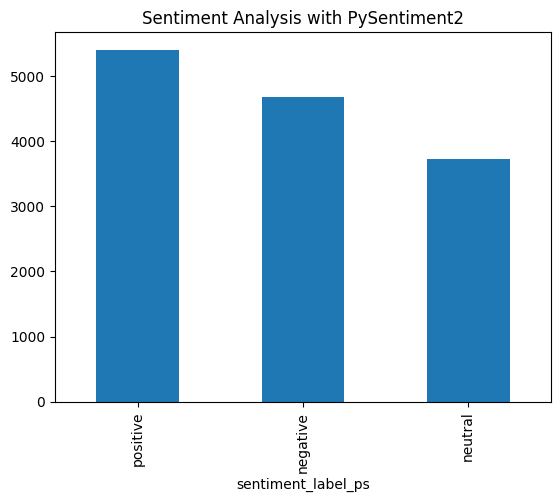

In [39]:
financial_news_clean.sentiment_label_ps.value_counts().plot(kind='bar', title='Sentiment Analysis with PySentiment2')

<Axes: title={'center': 'Sentiment Analysis with FinBERT'}, xlabel='sentiment_label_finbert'>

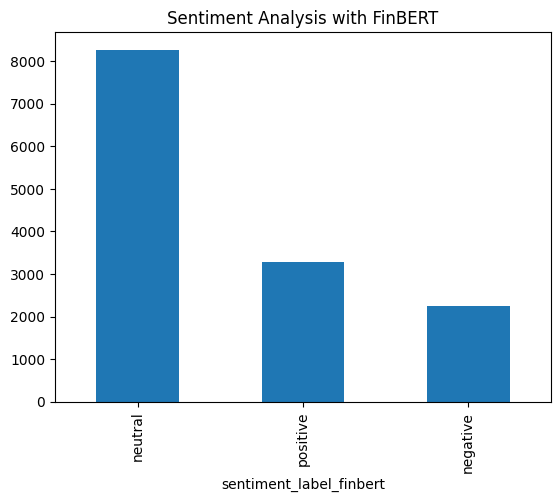

In [40]:
financial_news_clean.sentiment_label_finbert.value_counts().plot(kind='bar', title='Sentiment Analysis with FinBERT')

In [41]:
financial_news_clean.to_csv('../data/processed/financial_news_clean.csv', index=False)

In [42]:
# calcular la riqueza léxica
financial_news_clean['lexical richness'] = financial_news_clean['tokens'].apply(lambda x: len(set(x)) / len(x))

In [43]:
# Unir todos los textos
all_words = ' '.join(financial_news_clean['cleaned_text'].values)
all_words = nltk.word_tokenize(all_words)

# vocabulario
vocabulary = set(all_words)

riqueza_lexica = len(vocabulary) / len(all_words)

# Contar las palabras
word_counts = nltk.FreqDist(all_words)

Riqueza léxica: 0.01106328372545545


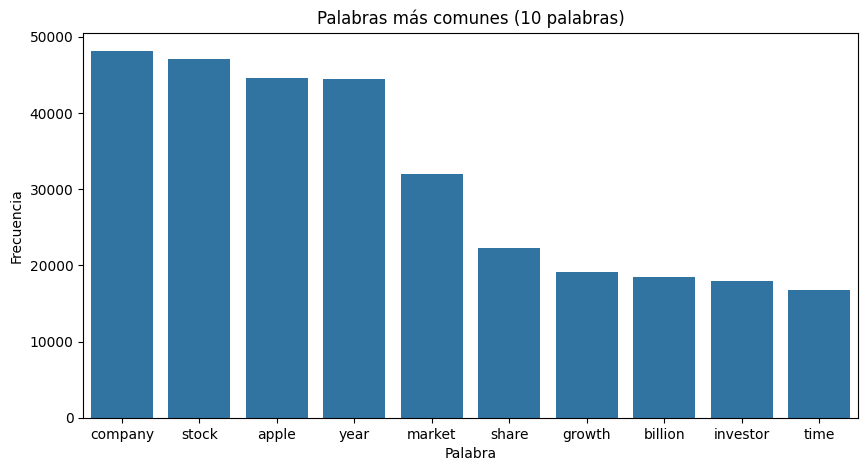

In [44]:
print(f"Riqueza léxica: {riqueza_lexica}")
top_words = 10
x = word_counts.most_common(top_words)
y = [word[1] for word in x]
x = [word[0] for word in x]

plt.figure(figsize=(10,5))
sns.barplot(x=x, y=y)
plt.title(f'Palabras más comunes ({top_words} palabras)')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.show()

### N-grmas

In [45]:
bigrams = nltk.bigrams(all_words)
fdist = nltk.FreqDist(bigrams)
fdist.most_common(10)

[(('long', 'term'), 5456),
 (('year', 'year'), 4464),
 (('last', 'year'), 3985),
 (('berkshire', 'hathaway'), 3939),
 (('cash', 'flow'), 3544),
 (('apple', 'aapl'), 3488),
 (('per', 'share'), 3220),
 (('motley', 'fool'), 3094),
 (('stock', 'market'), 2912),
 (('wall', 'street'), 2842)]

<Axes: title={'center': 'Bigramas más comunes'}, xlabel='Samples', ylabel='Counts'>

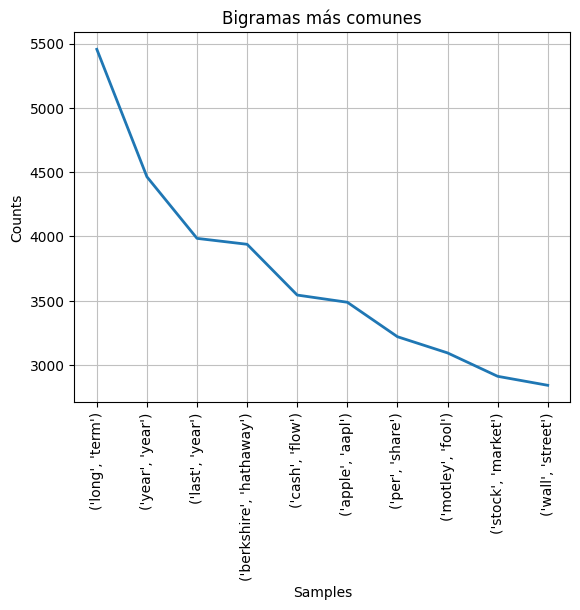

In [46]:
fdist.plot(10, title='Bigramas más comunes')

<Axes: title={'center': 'Trigramas más comunes'}, xlabel='Samples', ylabel='Counts'>

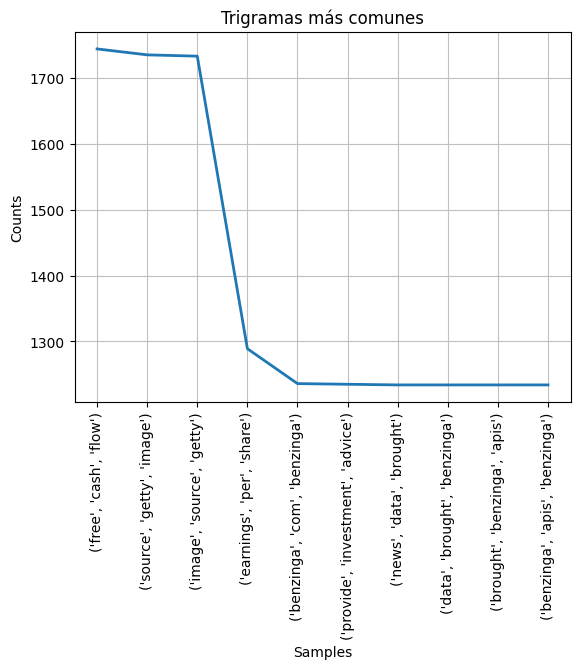

In [48]:
trigrams = ngrams(all_words, 3)
fdist = nltk.FreqDist(trigrams)
fdist.most_common(10)
fdist.plot(10, title='Trigramas más comunes')

In [49]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_words)

In [50]:
finder.apply_freq_filter(10)
finder.nbest(bigram_measures.pmi, 10)

[('fils', 'aime'),
 ('virax', 'biolabs'),
 ('krispy', 'kreme'),
 ('anheuser', 'busch'),
 ('canaccord', 'genuity'),
 ('kristy', 'akullian'),
 ('reggie', 'fils'),
 ('sergey', 'brin'),
 ('shmuel', 'barel'),
 ('kleiner', 'perkins')]

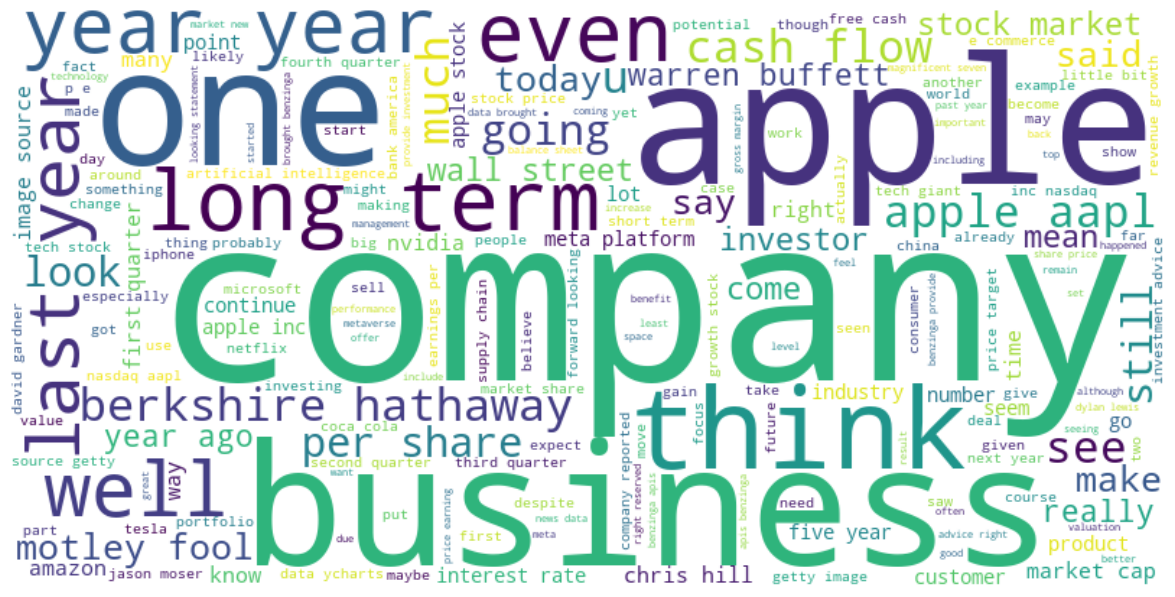

In [51]:
# Generar una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Visualizar la nube de palabras
plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: xlabel='ticker'>

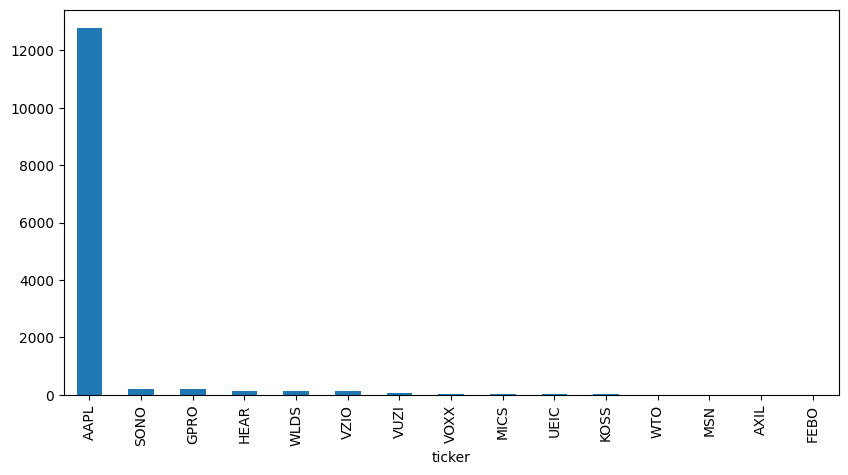

In [52]:
financial_news_clean.ticker.value_counts().plot(kind='bar', figsize=(10, 5))